In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot as plt
import scipy as sp
import seaborn as sns
#from plotting import annotate_cor
#from matplotlib.lines import Line2D
#from functools import partial
#from scipy import stats


sns.set(style='ticks', context='paper',
        rc={'font.size': 6, 
            'axes.titlesize': 7,
            'axes.labelsize': 7,
            'axes.labelpad': 2,
            'xtick.labelsize': 5,
            'ytick.labelsize': 5,
            'legend.title_fontsize' : 5.5,
            'legend.fontsize' : 5.5,
            'legend.markerscale': 0.5,
            'axes.spines.top': False,
            'axes.spines.right': False,
            'axes.linewidth': 0.4,
            'xtick.major.width': 0.4,
            'ytick.major.width': 0.4,
            'xtick.major.size': 2.5,
            'ytick.major.size': 2.5,
            'xtick.minor.size': 1.5,
            'ytick.minor.size': 1.5,
            'xtick.minor.width': 0.2,
            'ytick.minor.width': 0.2,
            'figure.constrained_layout.use': True,
            'figure.dpi': 200})

id_columns = ['architecture', 'task', 'kind', 'source', 'layer']

tf_to_pt_layer_map = {'encode_2': 'layer1.0.relu', 'encode_3': 'layer1.1.relu', 
                      'encode_4': 'layer2.0.relu', 'encode_5': 'layer2.1.relu', 
                      'encode_6': 'layer3.0.relu', 'encode_7': 'layer3.1.relu', 
                      'encode_8': 'layer4.0.relu', 'encode_9': 'layer4.1.relu'}

position_tf_to_pt_map = {}
for l in ['encode_8', 'encode_9']:
    for x in range(7):
        for y in range(7):
            p = f'.position{x}x{y}'
            tf = l+p
            if l == 'encode_8':
                position_tf_to_pt_map[tf] = 'layer4.0.relu'+p
            if l == 'encode_9':
                position_tf_to_pt_map[tf] = 'layer4.1.relu'+p


#data = pd.merge(pd.read_csv(f'/home/wtownle1/encoder_dimensionality/results_marcc/spatialPCA/eigspectra_untrained|dataset:{dataset}|pooling:spatial_pca|grayscale:False.csv'), pd.read_csv(f'/home/wtownle1/encoder_dimensionality/results_marcc/spatialPCA/eigmetrics_untrained|dataset:{dataset}|pooling:spatial_pca|grayscale:False.csv'),on=id_columns)


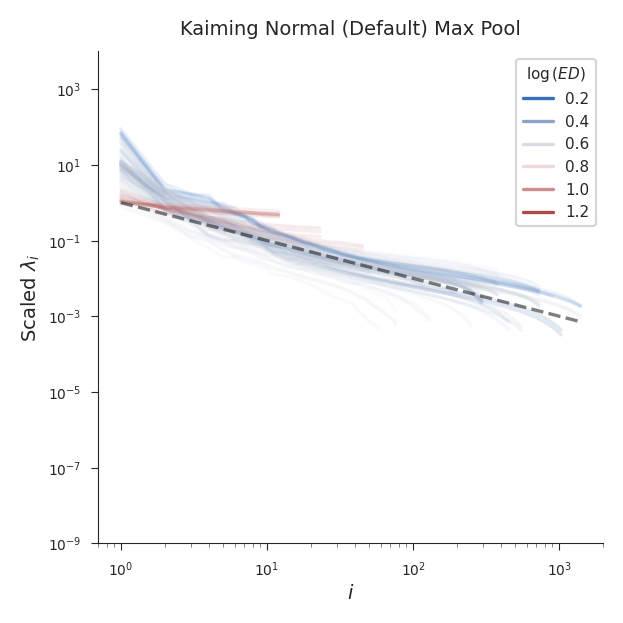

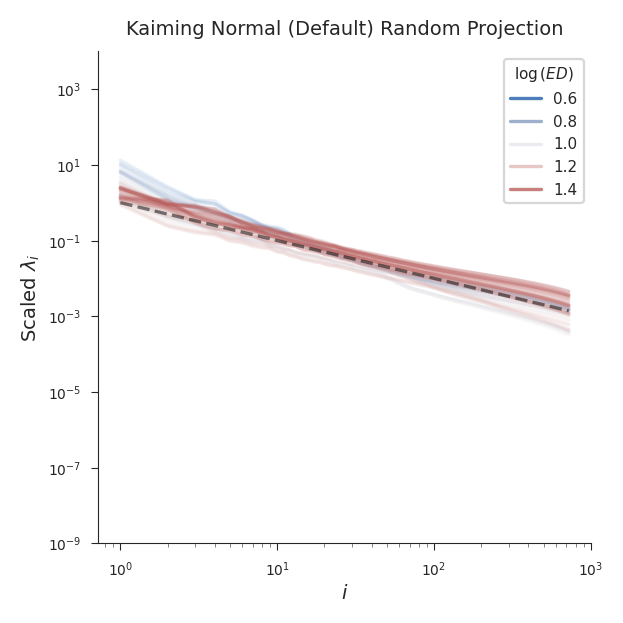

In [4]:
#kaiming normal (Default) eigenspectra
# - CNNs include convnext

#max pooling
data = pd.merge(pd.read_csv(f'../../results_marcc/untrained/eigspectra_unt|dataset:imagenet|pooling:max|grayscale:False.csv'),
                pd.read_csv(f'../../results_marcc/untrained/eigmetrics_unt|dataset:imagenet|pooling:max|grayscale:False.csv'),
                on=id_columns)
data.loc[:, 'layer'] = data['layer'].replace(tf_to_pt_layer_map)
data['id'] = data[id_columns].sum(axis='columns')
data = data[ (data['architecture'] != 'MaxViT') & (data['architecture'] != 'Swin_t') & (data['architecture'] != 'VGG16')]

# Remove outlier low-variance points at the final PCs
def is_outlier(i):
    i = np.log(i)
    cutoff = 0.95 * i.iloc[-1]
    return i > cutoff
outlier = data.groupby(id_columns)['n'].transform(is_outlier)
data = data[~outlier]

# Set y-intercept to 1
def get_scaled_var(x):
    i, y = x['n'].values, x['variance'].values
    i, y = np.log(i), np.log(y)
    intercept = LinearRegression().fit(i.reshape(-1, 1), y).intercept_
    intercept = np.exp(intercept)
    return x['variance'] / intercept
scaled_var = data.groupby(id_columns).apply(get_scaled_var)
scaled_var = scaled_var.reset_index(id_columns, drop=True)
data['scaled_variance'] = scaled_var

# Log(ED)
data['log_ed'] = np.log10(data['effective dimensionality'])

fig, ax = plt.subplots(figsize=(3, 3))

sns.lineplot(data=data, x='n', y='scaled_variance', hue='log_ed',
             units='id', alpha=0.1, estimator=None,
             palette=sns.color_palette('vlag', as_cmap=True), ax=ax)
ax.plot([1, data.n.max()], [1, 1 / data.n.max()], linestyle='--', color='black', alpha=0.5)
ax.set(xlabel=r'$i$', ylabel=r'Scaled $\lambda_i$', xscale='log', yscale='log', title='Kaiming Normal (Default) Max Pool')
ax.set_ylim(bottom=10**(-9), top=10**4)
ax.legend(title=r'$\log{(ED)}$')


#random projection
data = pd.merge(pd.read_csv(f'../../results_marcc/untrained/eigspectra_unt|dataset:imagenet|pooling:none|grayscale:False.csv'),
                pd.read_csv(f'../../results_marcc/untrained/eigmetrics_unt|dataset:imagenet|pooling:none|grayscale:False.csv'),
                on=id_columns)
data.loc[:, 'layer'] = data['layer'].replace(tf_to_pt_layer_map)
data['id'] = data[id_columns].sum(axis='columns')
data = data[ (data['architecture'] != 'MaxViT') & (data['architecture'] != 'Swin_t') & (data['architecture'] != 'VGG16')]

# Remove outlier low-variance points at the final PCs
def is_outlier(i):
    i = np.log(i)
    cutoff = 0.95 * i.iloc[-1]
    return i > cutoff
outlier = data.groupby(id_columns)['n'].transform(is_outlier)
data = data[~outlier]

# Set y-intercept to 1
def get_scaled_var(x):
    i, y = x['n'].values, x['variance'].values
    i, y = np.log(i), np.log(y)
    intercept = LinearRegression().fit(i.reshape(-1, 1), y).intercept_
    intercept = np.exp(intercept)
    return x['variance'] / intercept
scaled_var = data.groupby(id_columns).apply(get_scaled_var)
scaled_var = scaled_var.reset_index(id_columns, drop=True)
data['scaled_variance'] = scaled_var

# Log(ED)
data['log_ed'] = np.log10(data['effective dimensionality'])

fig, ax = plt.subplots(figsize=(3, 3))

sns.lineplot(data=data, x='n', y='scaled_variance', hue='log_ed',
             units='id', alpha=0.1, estimator=None,
             palette=sns.color_palette('vlag', as_cmap=True), ax=ax)
ax.plot([1, data.n.max()], [1, 1 / data.n.max()], linestyle='--', color='black', alpha=0.5)
ax.set(xlabel=r'$i$', ylabel=r'Scaled $\lambda_i$', xscale='log', yscale='log', title='Kaiming Normal (Default) Random Projection')
ax.set_ylim(bottom=10**(-9), top=10**4)
ax.legend(title=r'$\log{(ED)}$')



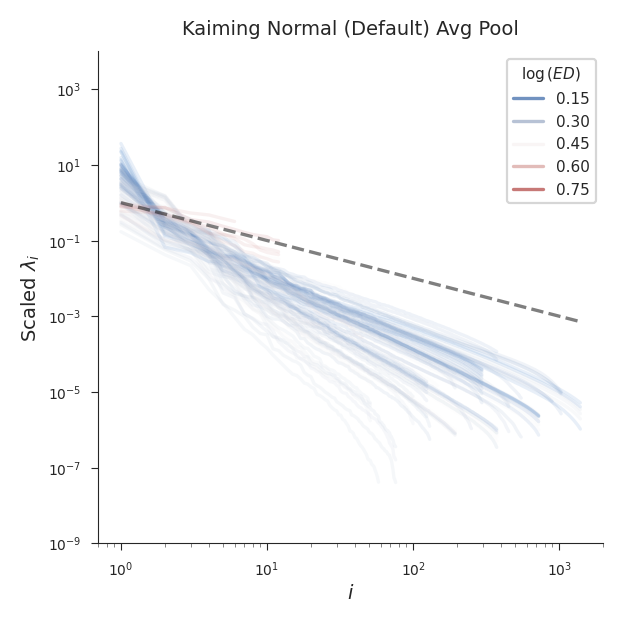

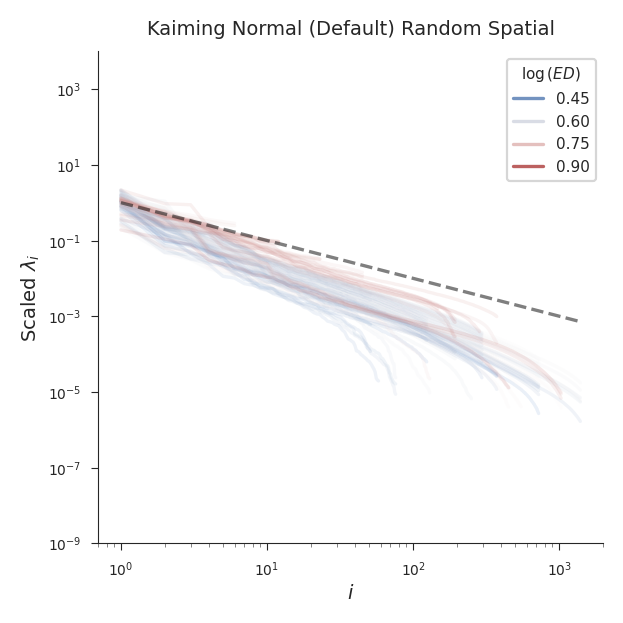

In [5]:
#kaiming normal eigenspectra

#avg pooling
data = pd.merge(pd.read_csv(f'../../results_marcc/untrained/eigspectra_unt|dataset:imagenet|pooling:avg|grayscale:False.csv'),
                pd.read_csv(f'../../results_marcc/untrained/eigmetrics_unt|dataset:imagenet|pooling:avg|grayscale:False.csv'),
                on=id_columns)
data.loc[:, 'layer'] = data['layer'].replace(tf_to_pt_layer_map)
data['id'] = data[id_columns].sum(axis='columns')
data = data[ (data['architecture'] != 'MaxViT') & (data['architecture'] != 'Swin_t') & (data['architecture'] != 'VGG16')]

# Remove outlier low-variance points at the final PCs
def is_outlier(i):
    i = np.log(i)
    cutoff = 0.95 * i.iloc[-1]
    return i > cutoff
outlier = data.groupby(id_columns)['n'].transform(is_outlier)
data = data[~outlier]

# Set y-intercept to 1
def get_scaled_var(x):
    i, y = x['n'].values, x['variance'].values
    i, y = np.log(i), np.log(y)
    intercept = LinearRegression().fit(i.reshape(-1, 1), y).intercept_
    intercept = np.exp(intercept)
    return x['variance'] / intercept
scaled_var = data.groupby(id_columns).apply(get_scaled_var)
scaled_var = scaled_var.reset_index(id_columns, drop=True)
data['scaled_variance'] = scaled_var

# Log(ED)
data['log_ed'] = np.log10(data['effective dimensionality'])

fig, ax = plt.subplots(figsize=(3, 3))

sns.lineplot(data=data, x='n', y='scaled_variance', hue='log_ed',
             units='id', alpha=0.1, estimator=None,
             palette=sns.color_palette('vlag', as_cmap=True), ax=ax)
ax.plot([1, data.n.max()], [1, 1 / data.n.max()], linestyle='--', color='black', alpha=0.5)
ax.set(xlabel=r'$i$', ylabel=r'Scaled $\lambda_i$', xscale='log', yscale='log', title='Kaiming Normal (Default) Avg Pool')
ax.set_ylim(bottom=10**(-9), top=10**4)
ax.legend(title=r'$\log{(ED)}$')


#random spatial
data = pd.merge(pd.read_csv(f'../../results_marcc/untrained/eigspectra_unt|dataset:imagenet|pooling:random_spatial|grayscale:False.csv'),
                pd.read_csv(f'../../results_marcc/untrained/eigmetrics_unt|dataset:imagenet|pooling:random_spatial|grayscale:False.csv'),
                on=id_columns)
data.loc[:, 'layer'] = data['layer'].replace(tf_to_pt_layer_map)
data['id'] = data[id_columns].sum(axis='columns')
data = data[ (data['architecture'] != 'MaxViT') & (data['architecture'] != 'Swin_t') & (data['architecture'] != 'VGG16')]

# Remove outlier low-variance points at the final PCs
def is_outlier(i):
    i = np.log(i)
    cutoff = 0.95 * i.iloc[-1]
    return i > cutoff
outlier = data.groupby(id_columns)['n'].transform(is_outlier)
data = data[~outlier]

# Set y-intercept to 1
def get_scaled_var(x):
    i, y = x['n'].values, x['variance'].values
    i, y = np.log(i), np.log(y)
    intercept = LinearRegression().fit(i.reshape(-1, 1), y).intercept_
    intercept = np.exp(intercept)
    return x['variance'] / intercept
scaled_var = data.groupby(id_columns).apply(get_scaled_var)
scaled_var = scaled_var.reset_index(id_columns, drop=True)
data['scaled_variance'] = scaled_var

# Log(ED)
data['log_ed'] = np.log10(data['effective dimensionality'])

fig, ax = plt.subplots(figsize=(3, 3))

sns.lineplot(data=data, x='n', y='scaled_variance', hue='log_ed',
             units='id', alpha=0.1, estimator=None,
             palette=sns.color_palette('vlag', as_cmap=True), ax=ax)
ax.plot([1, data.n.max()], [1, 1 / data.n.max()], linestyle='--', color='black', alpha=0.5)
ax.set(xlabel=r'$i$', ylabel=r'Scaled $\lambda_i$', xscale='log', yscale='log', title='Kaiming Normal (Default) Random Spatial')
ax.set_ylim(bottom=10**(-9), top=10**4)
ax.legend(title=r'$\log{(ED)}$')

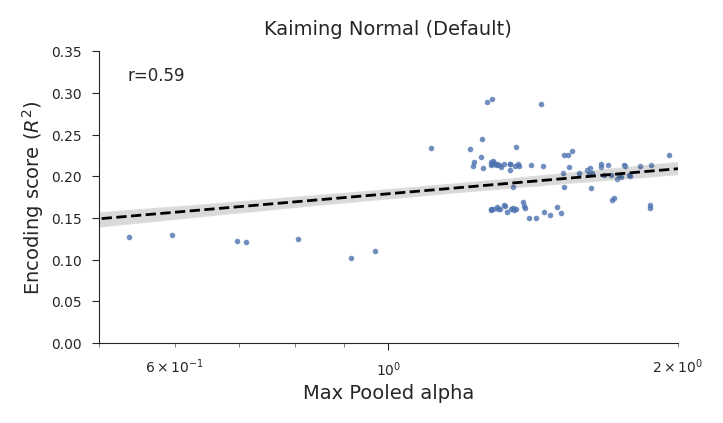

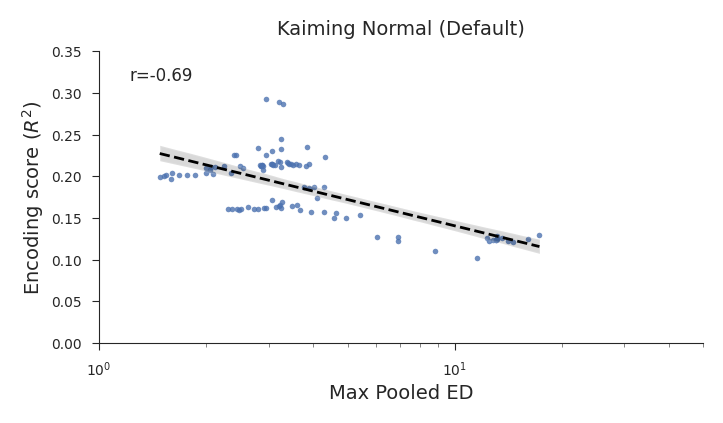

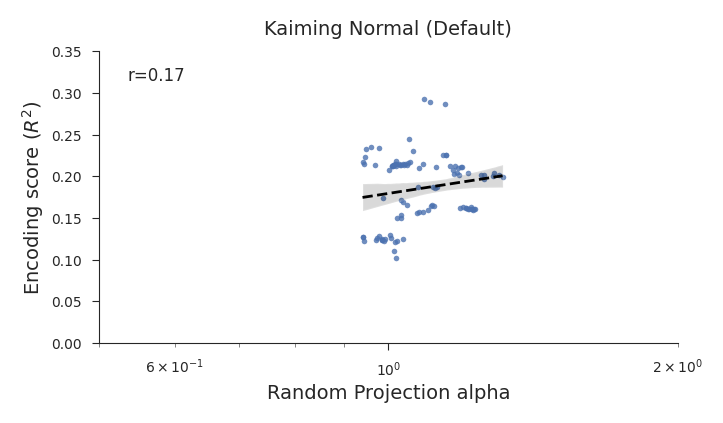

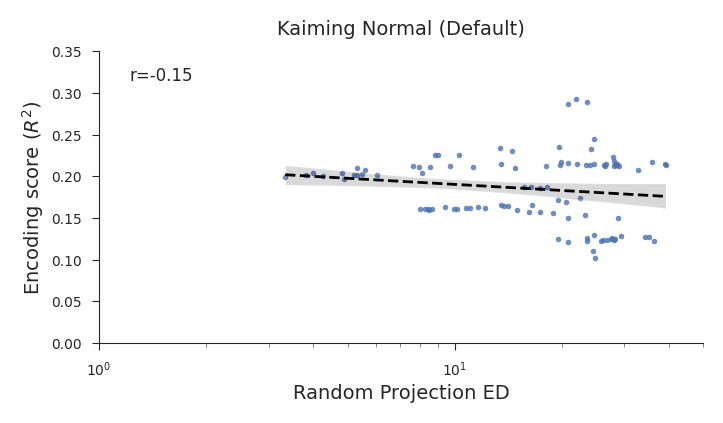

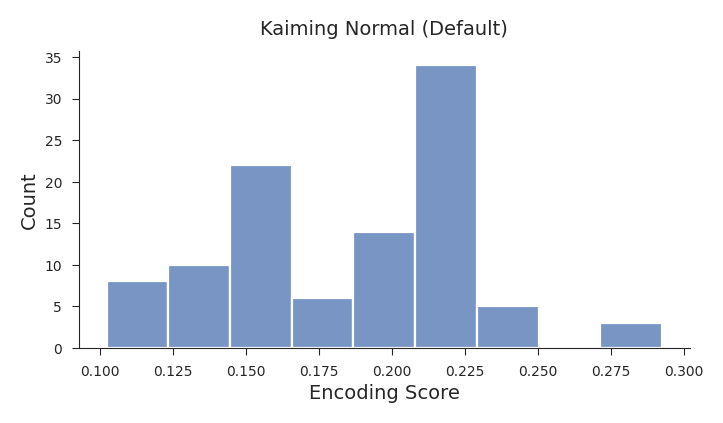

In [6]:
#kaiming normal (default) encoding score
# - cnn includes convnext
# **different column values somewhere in encoding and eigenmetrics_unt**

#max pooling
d1 = pd.read_csv(f'../../results_marcc/untrained/encoding|benchmark:dicarlo.MajajHong2015.IT.public-pls|pooling:none.csv')
d1 = d1[ (d1['kind'] == 'Untrained') ]
d2 = pd.read_csv(f'../../results_marcc/untrained/eigmetrics_unt|dataset:imagenet|pooling:max|grayscale:False.csv')
d2 = d2[ (d2['architecture'] != 'MaxViT') & (d2['architecture'] != 'Swin_t') & (d2['architecture'] != 'VGG16')]
d2.loc[:, 'architecture'] = d2['architecture'].replace({'MNASNet1_4':'MNASNet13'})
data = pd.merge(d1, d2, on=id_columns)
data.loc[:, 'layer'] = data['layer'].replace(tf_to_pt_layer_map)

r, p = sp.stats.pearsonr(data['alpha'], data['score'])

fig, ax = plt.subplots(1, 1, figsize=(3.5, 2))

sns.regplot(data=data, x='alpha', y='score', 
            logx=True,
            scatter_kws={'alpha': 0.8, 's': 4, 'linewidth': 0}, 
            line_kws={'color': 'black', 'linestyle': '--', 'linewidth': 1}, 
            ax=ax)
ax.set(xlabel='Max Pooled alpha', ylabel=r'Encoding score ($R^2$)', xscale='log', title='Kaiming Normal (Default)')
ax.text(.05, .9, 'r={:.2f}'.format(r), transform=ax.transAxes)
ax.set_xlim(0.5, 2)
ax.set_ylim(bottom=0, top=0.35)
#plt.savefig('saved/results_ED-vs-encoding-all.png', dpi=300)
plt.show()

#ED
r, p = sp.stats.pearsonr(data['effective dimensionality'], data['score'])

fig, ax = plt.subplots(1, 1, figsize=(3.5, 2))

sns.regplot(data=data, x='effective dimensionality', y='score', 
            logx=True,
            scatter_kws={'alpha': 0.8, 's': 4, 'linewidth': 0}, 
            line_kws={'color': 'black', 'linestyle': '--', 'linewidth': 1}, 
            ax=ax)
ax.set(xlabel='Max Pooled ED', ylabel=r'Encoding score ($R^2$)', xscale='log', title='Kaiming Normal (Default)')
ax.text(.05, .9, 'r={:.2f}'.format(r), transform=ax.transAxes)
ax.set_xlim(1, 50)
ax.set_ylim(bottom=0, top=0.35)
#plt.savefig('saved/results_ED-vs-encoding-all.png', dpi=300)
plt.show()


#no pooling
d1 = pd.read_csv(f'../../results_marcc/untrained/encoding|benchmark:dicarlo.MajajHong2015.IT.public-pls|pooling:none.csv')
d1 = d1[ (d1['kind'] == 'Untrained') ]
d2 = pd.read_csv(f'../../results_marcc/untrained/eigmetrics_unt|dataset:imagenet|pooling:none|grayscale:False.csv')
d2 = d2[ (d2['architecture'] != 'MaxViT') & (d2['architecture'] != 'Swin_t') & (d2['architecture'] != 'VGG16')]
d2.loc[:, 'architecture'] = d2['architecture'].replace({'MNASNet1_4': 'MNASNet13'})
data = pd.merge(d1, d2, on=id_columns)
data.loc[:, 'layer'] = data['layer'].replace(tf_to_pt_layer_map)

r_np, p_np = sp.stats.pearsonr(data['alpha'], data['score'])

fig, ax = plt.subplots(1, 1, figsize=(3.5, 2))


sns.regplot(data=data, x='alpha', y='score', 
            logx=True,
            scatter_kws={'alpha': 0.8, 's': 4, 'linewidth': 0}, 
            line_kws={'color': 'black', 'linestyle': '--', 'linewidth': 1}, 
            ax=ax)
ax.set(xlabel='Random Projection alpha', ylabel=r'Encoding score ($R^2$)', xscale='log', title='Kaiming Normal (Default)')
ax.text(.05, .9, 'r={:.2f}'.format(r_np), transform=ax.transAxes)
ax.set_xlim(0.5, 2)
ax.set_ylim(bottom=0, top=0.35)
#plt.savefig('saved/results_ED-vs-encoding-all.png', dpi=300)
plt.show()


#ED
r_np, p_np = sp.stats.pearsonr(data['effective dimensionality'], data['score'])

fig, ax = plt.subplots(1, 1, figsize=(3.5, 2))


sns.regplot(data=data, x='effective dimensionality', y='score', 
            logx=True,
            scatter_kws={'alpha': 0.8, 's': 4, 'linewidth': 0}, 
            line_kws={'color': 'black', 'linestyle': '--', 'linewidth': 1}, 
            ax=ax)
ax.set(xlabel='Random Projection ED', ylabel=r'Encoding score ($R^2$)', xscale='log', title='Kaiming Normal (Default)')
ax.text(.05, .9, 'r={:.2f}'.format(r_np), transform=ax.transAxes)
ax.set_xlim(1, 50)
ax.set_ylim(bottom=0, top=0.35)
#plt.savefig('saved/results_ED-vs-encoding-all.png', dpi=300)
plt.show()

fig, ax = plt.subplots(figsize=(3.5, 2))
sns.histplot(data=data, x='score')
ax.set(xlabel='Encoding Score', title='Kaiming Normal (Default)')
plt.show()

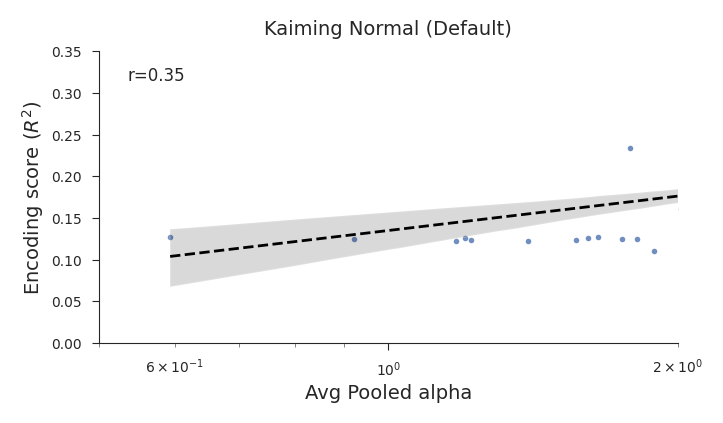

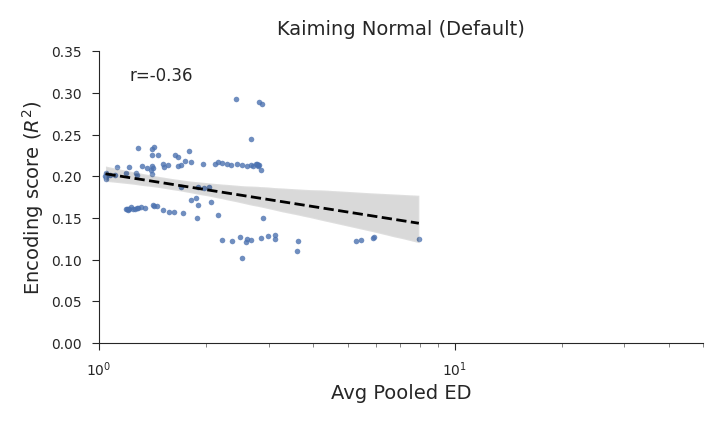

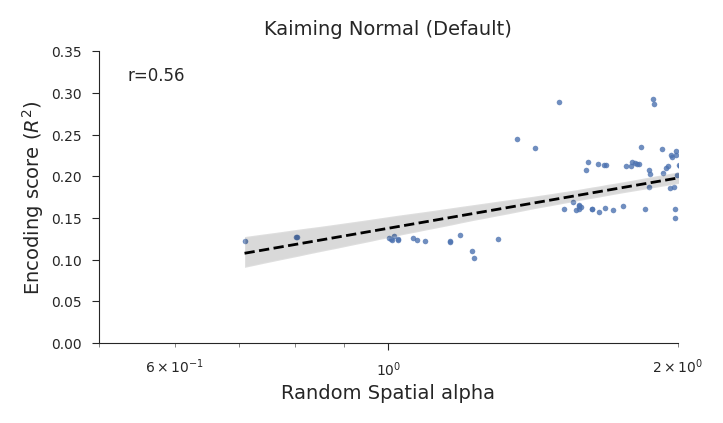

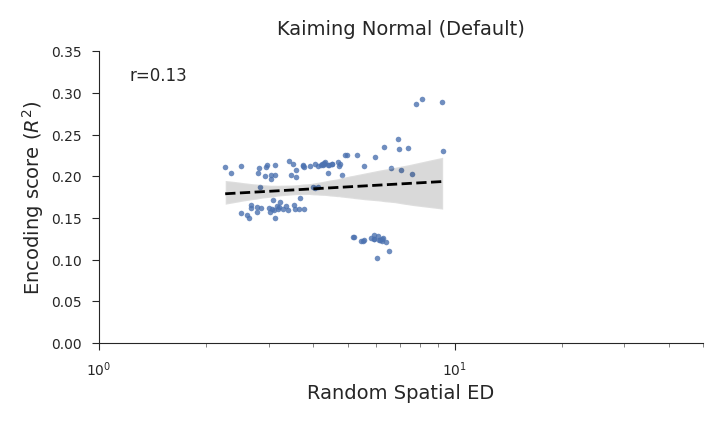

In [7]:
#kaiming normal (default) encoding score

#avg pooling
d1 = pd.read_csv(f'../../results_marcc/untrained/encoding|benchmark:dicarlo.MajajHong2015.IT.public-pls|pooling:none.csv')
d1 = d1[ (d1['kind'] == 'Untrained') ]
d2 = pd.read_csv(f'../../results_marcc/untrained/eigmetrics_unt|dataset:imagenet|pooling:avg|grayscale:False.csv')
d2 = d2[ (d2['architecture'] != 'MaxViT') & (d2['architecture'] != 'Swin_t') & (d2['architecture'] != 'VGG16')]
d2.loc[:, 'architecture'] = d2['architecture'].replace({'MNASNet1_4': 'MNASNet13'})
data = pd.merge(d1, d2, on=id_columns)
data.loc[:, 'layer'] = data['layer'].replace(tf_to_pt_layer_map)


r, p = sp.stats.pearsonr(data['alpha'], data['score'])

fig, ax = plt.subplots(1, 1, figsize=(3.5, 2))

sns.regplot(data=data, x='alpha', y='score', 
            logx=True,
            scatter_kws={'alpha': 0.8, 's': 4, 'linewidth': 0}, 
            line_kws={'color': 'black', 'linestyle': '--', 'linewidth': 1}, 
            ax=ax)
ax.set(xlabel='Avg Pooled alpha', ylabel=r'Encoding score ($R^2$)', xscale='log', title='Kaiming Normal (Default)')
ax.text(.05, .9, 'r={:.2f}'.format(r), transform=ax.transAxes)
ax.set_xlim(0.5, 2)
ax.set_ylim(bottom=0, top=0.35)
#plt.savefig('saved/results_ED-vs-encoding-all.png', dpi=300)
plt.show()

#ED
r, p = sp.stats.pearsonr(data['effective dimensionality'], data['score'])

fig, ax = plt.subplots(1, 1, figsize=(3.5, 2))

sns.regplot(data=data, x='effective dimensionality', y='score', 
            logx=True,
            scatter_kws={'alpha': 0.8, 's': 4, 'linewidth': 0}, 
            line_kws={'color': 'black', 'linestyle': '--', 'linewidth': 1}, 
            ax=ax)
ax.set(xlabel='Avg Pooled ED', ylabel=r'Encoding score ($R^2$)', xscale='log', title='Kaiming Normal (Default)')
ax.text(.05, .9, 'r={:.2f}'.format(r), transform=ax.transAxes)
ax.set_xlim(1, 50)
ax.set_ylim(bottom=0, top=0.35)
#plt.savefig('saved/results_ED-vs-encoding-all.png', dpi=300)
plt.show()


#random spatial
d1 = pd.read_csv(f'../../results_marcc/untrained/encoding|benchmark:dicarlo.MajajHong2015.IT.public-pls|pooling:none.csv')
d1 = d1[ (d1['kind'] == 'Untrained') ]
d2 = pd.read_csv(f'../../results_marcc/untrained/eigmetrics_unt|dataset:imagenet|pooling:random_spatial|grayscale:False.csv')
d2 = d2[ (d2['architecture'] != 'MaxViT') & (d2['architecture'] != 'Swin_t') & (d2['architecture'] != 'VGG16')]
d2.loc[:, 'architecture'] = d2['architecture'].replace({'MNASNet1_4': 'MNASNet13'})
data = pd.merge(d1, d2, on=id_columns)
data.loc[:, 'layer'] = data['layer'].replace(tf_to_pt_layer_map)

r_np, p_np = sp.stats.pearsonr(data['alpha'], data['score'])

fig, ax = plt.subplots(1, 1, figsize=(3.5, 2))


sns.regplot(data=data, x='alpha', y='score', 
            logx=True,
            scatter_kws={'alpha': 0.8, 's': 4, 'linewidth': 0}, 
            line_kws={'color': 'black', 'linestyle': '--', 'linewidth': 1}, 
            ax=ax)
ax.set(xlabel='Random Spatial alpha', ylabel=r'Encoding score ($R^2$)', xscale='log', title='Kaiming Normal (Default)')
ax.text(.05, .9, 'r={:.2f}'.format(r_np), transform=ax.transAxes)
ax.set_xlim(0.5, 2)
ax.set_ylim(bottom=0, top=0.35)
#plt.savefig('saved/results_ED-vs-encoding-all.png', dpi=300)
plt.show()


#ED
r_np, p_np = sp.stats.pearsonr(data['effective dimensionality'], data['score'])

fig, ax = plt.subplots(1, 1, figsize=(3.5, 2))


sns.regplot(data=data, x='effective dimensionality', y='score', 
            logx=True,
            scatter_kws={'alpha': 0.8, 's': 4, 'linewidth': 0}, 
            line_kws={'color': 'black', 'linestyle': '--', 'linewidth': 1}, 
            ax=ax)
ax.set(xlabel='Random Spatial ED', ylabel=r'Encoding score ($R^2$)', xscale='log', title='Kaiming Normal (Default)')
ax.text(.05, .9, 'r={:.2f}'.format(r_np), transform=ax.transAxes)
ax.set_xlim(1, 50)
ax.set_ylim(bottom=0, top=0.35)
#plt.savefig('saved/results_ED-vs-encoding-all.png', dpi=300)
plt.show()

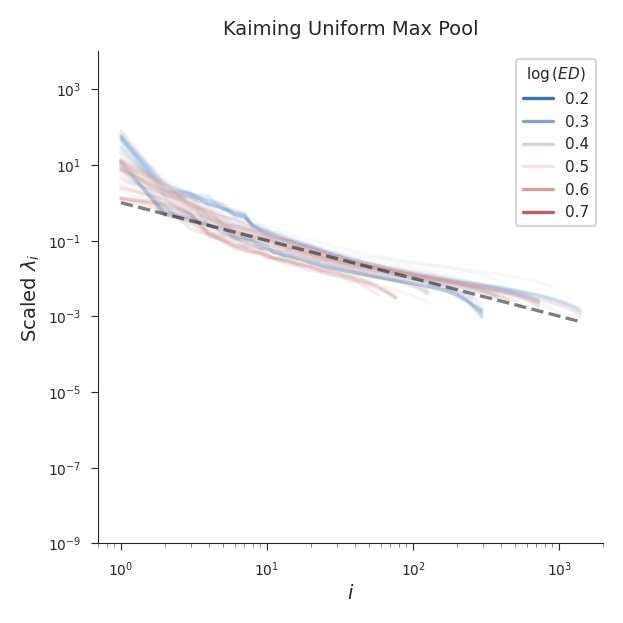

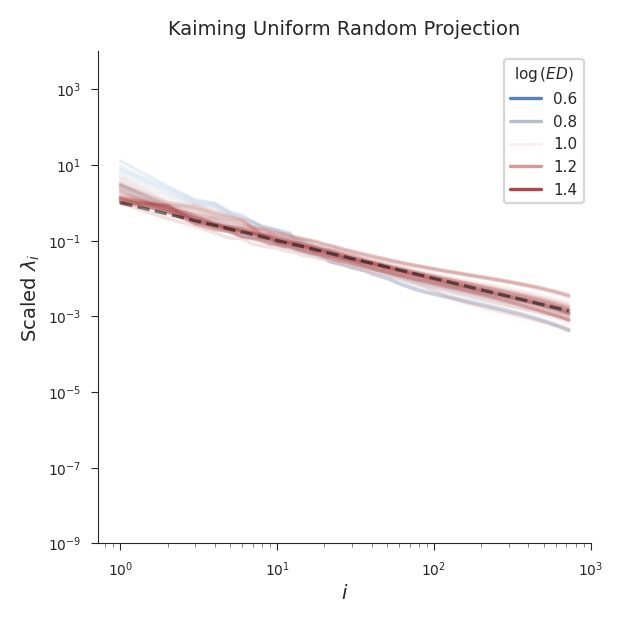

In [8]:
#kaiming uniform eigenspectra

#max pooling
data = pd.merge(pd.read_csv(f'../../results_marcc/untrained/eigspectra_KaiUni|dataset:imagenet|pooling:max|grayscale:False.csv'),
                pd.read_csv(f'../../results_marcc/untrained/eigmetrics_KaiUni|dataset:imagenet|pooling:max|grayscale:False.csv'),
                on=id_columns)
data.loc[:, 'layer'] = data['layer'].replace(tf_to_pt_layer_map)
data['id'] = data[id_columns].sum(axis='columns')
data = data[ (data['architecture'] != 'MaxViT') & (data['architecture'] != 'Swin_t')]

# Remove outlier low-variance points at the final PCs
def is_outlier(i):
    i = np.log(i)
    cutoff = 0.95 * i.iloc[-1]
    return i > cutoff
outlier = data.groupby(id_columns)['n'].transform(is_outlier)
data = data[~outlier]

# Set y-intercept to 1
def get_scaled_var(x):
    i, y = x['n'].values, x['variance'].values
    i, y = np.log(i), np.log(y)
    intercept = LinearRegression().fit(i.reshape(-1, 1), y).intercept_
    intercept = np.exp(intercept)
    return x['variance'] / intercept
scaled_var = data.groupby(id_columns).apply(get_scaled_var)
scaled_var = scaled_var.reset_index(id_columns, drop=True)
data['scaled_variance'] = scaled_var

# Log(ED)
data['log_ed'] = np.log10(data['effective dimensionality'])

fig, ax = plt.subplots(figsize=(3, 3))

sns.lineplot(data=data, x='n', y='scaled_variance', hue='log_ed',
             units='id', alpha=0.1, estimator=None,
             palette=sns.color_palette('vlag', as_cmap=True), ax=ax)
ax.plot([1, data.n.max()], [1, 1 / data.n.max()], linestyle='--', color='black', alpha=0.5)
ax.set(xlabel=r'$i$', ylabel=r'Scaled $\lambda_i$', xscale='log', yscale='log', title='Kaiming Uniform Max Pool')
ax.set_ylim(bottom=10**(-9), top=10**4)
ax.legend(title=r'$\log{(ED)}$')



#random projection
data = pd.merge(pd.read_csv(f'../../results_marcc/untrained/eigspectra_KaiUni|dataset:imagenet|pooling:none|grayscale:False.csv'),
                pd.read_csv(f'../../results_marcc/untrained/eigmetrics_KaiUni|dataset:imagenet|pooling:none|grayscale:False.csv'),
                on=id_columns)
data.loc[:, 'layer'] = data['layer'].replace(tf_to_pt_layer_map)
data['id'] = data[id_columns].sum(axis='columns')
data = data[ (data['architecture'] != 'MaxViT') & (data['architecture'] != 'Swin_t')]

# Remove outlier low-variance points at the final PCs
def is_outlier(i):
    i = np.log(i)
    cutoff = 0.95 * i.iloc[-1]
    return i > cutoff
outlier = data.groupby(id_columns)['n'].transform(is_outlier)
data = data[~outlier]

# Set y-intercept to 1
def get_scaled_var(x):
    i, y = x['n'].values, x['variance'].values
    i, y = np.log(i), np.log(y)
    intercept = LinearRegression().fit(i.reshape(-1, 1), y).intercept_
    intercept = np.exp(intercept)
    return x['variance'] / intercept
scaled_var = data.groupby(id_columns).apply(get_scaled_var)
scaled_var = scaled_var.reset_index(id_columns, drop=True)
data['scaled_variance'] = scaled_var

# Log(ED)
data['log_ed'] = np.log10(data['effective dimensionality'])

fig, ax = plt.subplots(figsize=(3, 3))

sns.lineplot(data=data, x='n', y='scaled_variance', hue='log_ed',
             units='id', alpha=0.1, estimator=None,
             palette=sns.color_palette('vlag', as_cmap=True), ax=ax)
ax.plot([1, data.n.max()], [1, 1 / data.n.max()], linestyle='--', color='black', alpha=0.5)
ax.set(xlabel=r'$i$', ylabel=r'Scaled $\lambda_i$', xscale='log', yscale='log', title='Kaiming Uniform Random Projection')
ax.set_ylim(bottom=10**(-9), top=10**4)
ax.legend(title=r'$\log{(ED)}$')

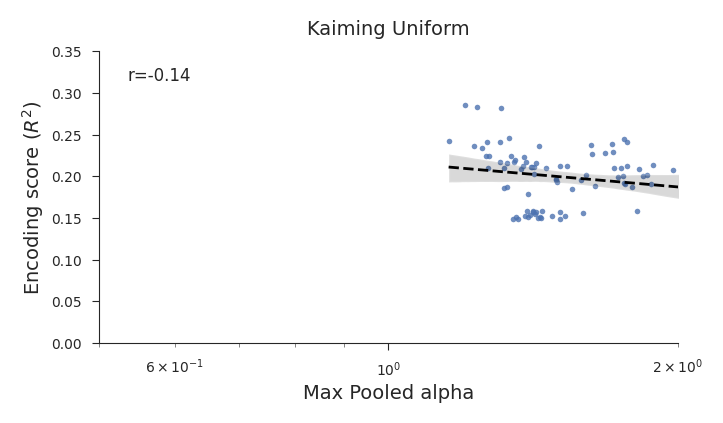

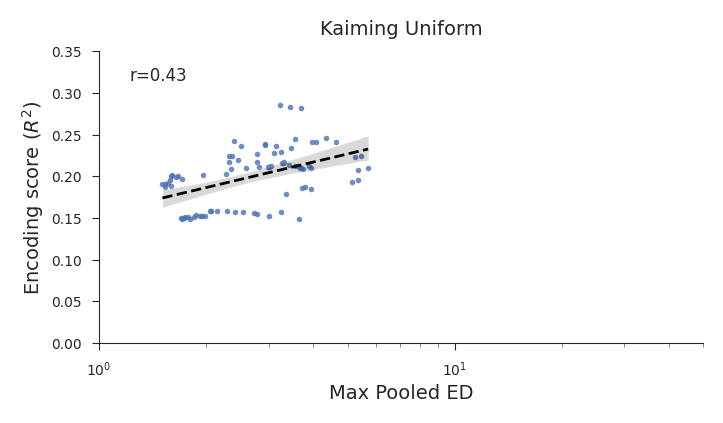

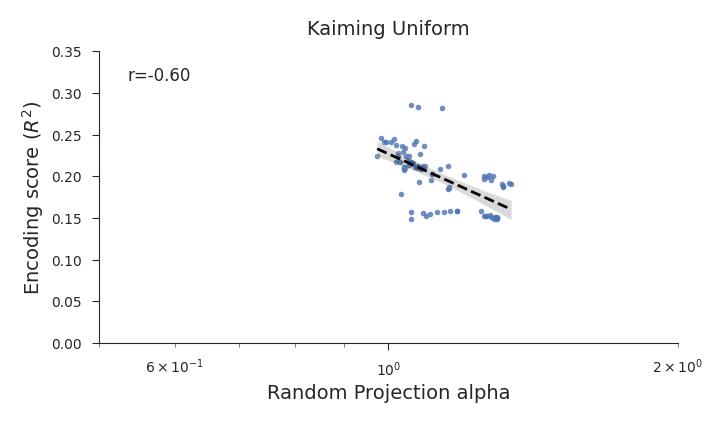

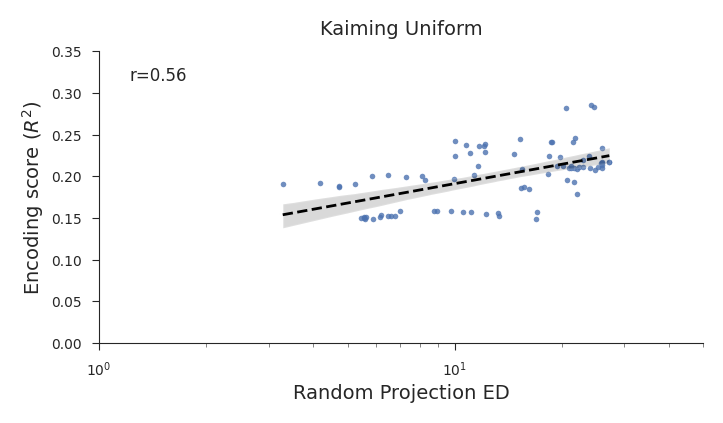

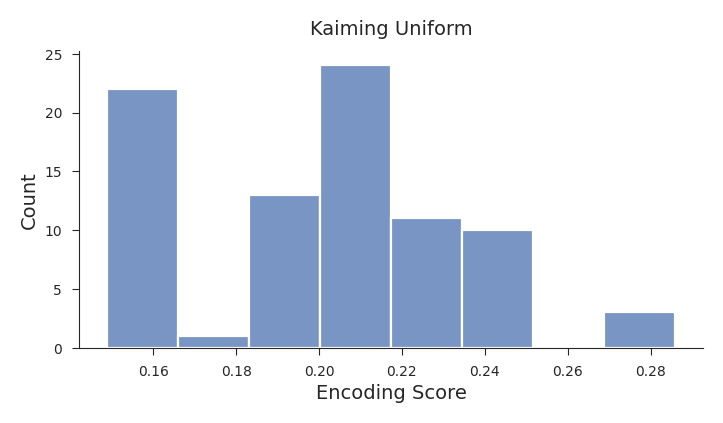

In [9]:
#kaiming uniform encoding score

#max pooling
data = pd.merge(pd.read_csv(f'../../results_marcc/untrained/encoding_KaiUni|benchmark:dicarlo.MajajHong2015.IT.public-pls|pooling:none.csv'),
                pd.read_csv(f'../../results_marcc/untrained/eigmetrics_KaiUni|dataset:imagenet|pooling:max|grayscale:False.csv'),
                on=id_columns)
data.loc[:, 'layer'] = data['layer'].replace(tf_to_pt_layer_map)
data = data[ (data['architecture'] != 'MaxViT') & (data['architecture'] != 'Swin_t')]

r, p = sp.stats.pearsonr(data['alpha'], data['score'])

fig, ax = plt.subplots(1, 1, figsize=(3.5, 2))

sns.regplot(data=data, x='alpha', y='score', 
            logx=True,
            scatter_kws={'alpha': 0.8, 's': 4, 'linewidth': 0}, 
            line_kws={'color': 'black', 'linestyle': '--', 'linewidth': 1}, 
            ax=ax)
ax.set(xlabel='Max Pooled alpha', ylabel=r'Encoding score ($R^2$)', xscale='log', title='Kaiming Uniform')
ax.text(.05, .9, 'r={:.2f}'.format(r), transform=ax.transAxes)
ax.set_xlim(0.5, 2)
ax.set_ylim(bottom=0, top=0.35)
#plt.savefig('saved/results_ED-vs-encoding-all.png', dpi=300)
plt.show()


#ED to encoding score
r2, p2 = sp.stats.pearsonr(data['effective dimensionality'], data['score'])

fig, ax = plt.subplots(1, 1, figsize=(3.5, 2))

sns.regplot(data=data, x='effective dimensionality', y='score', 
            logx=True,
            scatter_kws={'alpha': 0.8, 's': 4, 'linewidth': 0}, 
            line_kws={'color': 'black', 'linestyle': '--', 'linewidth': 1}, 
            ax=ax)
ax.set(xlabel='Max Pooled ED', ylabel=r'Encoding score ($R^2$)', xscale='log', title='Kaiming Uniform')
ax.text(.05, .9, 'r={:.2f}'.format(r2), transform=ax.transAxes)
ax.set_xlim(1, 50)
ax.set_ylim(bottom=0, top=0.35)
#plt.savefig('saved/results_ED-vs-encoding-all.png', dpi=300)
plt.show()


#random projection
data = pd.merge(pd.read_csv(f'../../results_marcc/untrained/encoding_KaiUni|benchmark:dicarlo.MajajHong2015.IT.public-pls|pooling:none.csv'),
                pd.read_csv(f'../../results_marcc/untrained/eigmetrics_KaiUni|dataset:imagenet|pooling:none|grayscale:False.csv'),
                on=id_columns)
data.loc[:, 'layer'] = data['layer'].replace(tf_to_pt_layer_map)
data = data[ (data['architecture'] != 'MaxViT') & (data['architecture'] != 'Swin_t')]

r, p = sp.stats.pearsonr(data['alpha'], data['score'])

fig, ax = plt.subplots(1, 1, figsize=(3.5, 2))

sns.regplot(data=data, x='alpha', y='score', 
            logx=True,
            scatter_kws={'alpha': 0.8, 's': 4, 'linewidth': 0}, 
            line_kws={'color': 'black', 'linestyle': '--', 'linewidth': 1}, 
            ax=ax)
ax.set(xlabel='Random Projection alpha', ylabel=r'Encoding score ($R^2$)', xscale='log', title='Kaiming Uniform')
ax.text(.05, .9, 'r={:.2f}'.format(r), transform=ax.transAxes)
ax.set_xlim(0.5, 2)
ax.set_ylim(bottom=0, top=0.35)
#plt.savefig('saved/results_ED-vs-encoding-all.png', dpi=300)
plt.show()


#ED to encoding score
r2, p2 = sp.stats.pearsonr(data['effective dimensionality'], data['score'])

fig, ax = plt.subplots(1, 1, figsize=(3.5, 2))

sns.regplot(data=data, x='effective dimensionality', y='score', 
            logx=True,
            scatter_kws={'alpha': 0.8, 's': 4, 'linewidth': 0}, 
            line_kws={'color': 'black', 'linestyle': '--', 'linewidth': 1}, 
            ax=ax)
ax.set(xlabel='Random Projection ED', ylabel=r'Encoding score ($R^2$)', xscale='log', title='Kaiming Uniform')
ax.text(.05, .9, 'r={:.2f}'.format(r2), transform=ax.transAxes)
ax.set_xlim(1, 50)
ax.set_ylim(bottom=0, top=0.35)
#plt.savefig('saved/results_ED-vs-encoding-all.png', dpi=300)
plt.show()

fig, ax = plt.subplots(figsize=(3.5, 2))
sns.histplot(data=data, x='score')
ax.set(xlabel='Encoding Score', title='Kaiming Uniform')
plt.show()

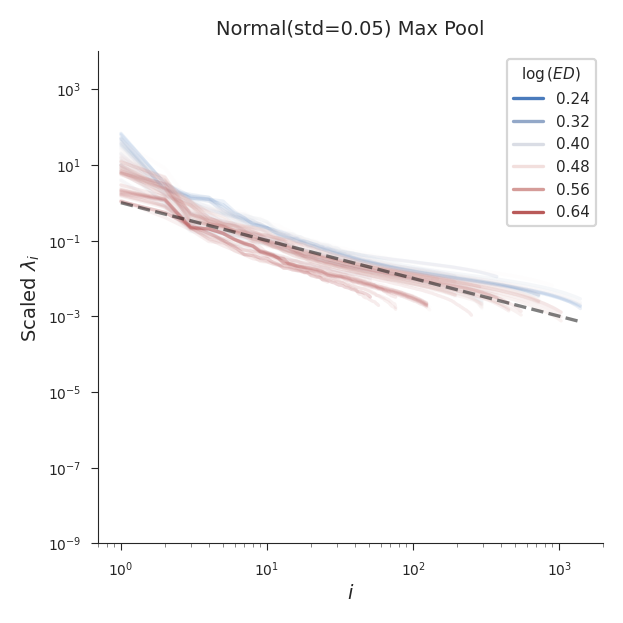

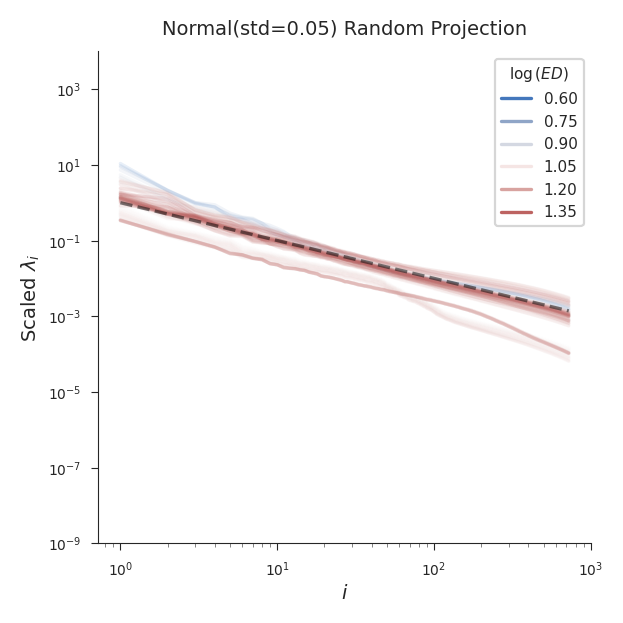

In [22]:
#normal eigenspectra

#max pooling
data = pd.merge(pd.read_csv(f'../../results_marcc/untrained/eigspectra_N|dataset:imagenet|pooling:max|grayscale:False.csv'),
                pd.read_csv(f'../../results_marcc/untrained/eigmetrics_N|dataset:imagenet|pooling:max|grayscale:False.csv'),
                on=id_columns)
data.loc[:, 'layer'] = data['layer'].replace(tf_to_pt_layer_map)
data['id'] = data[id_columns].sum(axis='columns')

# Remove outlier low-variance points at the final PCs
def is_outlier(i):
    i = np.log(i)
    cutoff = 0.95 * i.iloc[-1]
    return i > cutoff
outlier = data.groupby(id_columns)['n'].transform(is_outlier)
data = data[~outlier]

# Set y-intercept to 1
def get_scaled_var(x):
    i, y = x['n'].values, x['variance'].values
    i, y = np.log(i), np.log(y)
    intercept = LinearRegression().fit(i.reshape(-1, 1), y).intercept_
    intercept = np.exp(intercept)
    return x['variance'] / intercept
scaled_var = data.groupby(id_columns).apply(get_scaled_var)
scaled_var = scaled_var.reset_index(id_columns, drop=True)
data['scaled_variance'] = scaled_var

# Log(ED)
data['log_ed'] = np.log10(data['effective dimensionality'])

fig, ax = plt.subplots(figsize=(3, 3))

sns.lineplot(data=data, x='n', y='scaled_variance', hue='log_ed',
             units='id', alpha=0.1, estimator=None,
             palette=sns.color_palette('vlag', as_cmap=True), ax=ax)
ax.plot([1, data.n.max()], [1, 1 / data.n.max()], linestyle='--', color='black', alpha=0.5)
ax.set(xlabel=r'$i$', ylabel=r'Scaled $\lambda_i$', xscale='log', yscale='log', title='Normal(std=0.05) Max Pool')
ax.set_ylim(bottom=10**(-9), top=10**4)
ax.legend(title=r'$\log{(ED)}$')



#random projection
data = pd.merge(pd.read_csv(f'../../results_marcc/untrained/eigspectra_N|dataset:imagenet|pooling:none|grayscale:False.csv'),
                pd.read_csv(f'../../results_marcc/untrained/eigmetrics_N|dataset:imagenet|pooling:none|grayscale:False.csv'),
                on=id_columns)
data.loc[:, 'layer'] = data['layer'].replace(tf_to_pt_layer_map)
data['id'] = data[id_columns].sum(axis='columns')

# Remove outlier low-variance points at the final PCs
def is_outlier(i):
    i = np.log(i)
    cutoff = 0.95 * i.iloc[-1]
    return i > cutoff
outlier = data.groupby(id_columns)['n'].transform(is_outlier)
data = data[~outlier]

# Set y-intercept to 1
def get_scaled_var(x):
    i, y = x['n'].values, x['variance'].values
    i, y = np.log(i), np.log(y)
    intercept = LinearRegression().fit(i.reshape(-1, 1), y).intercept_
    intercept = np.exp(intercept)
    return x['variance'] / intercept
scaled_var = data.groupby(id_columns).apply(get_scaled_var)
scaled_var = scaled_var.reset_index(id_columns, drop=True)
data['scaled_variance'] = scaled_var

# Log(ED)
data['log_ed'] = np.log10(data['effective dimensionality'])

fig, ax = plt.subplots(figsize=(3, 3))

sns.lineplot(data=data, x='n', y='scaled_variance', hue='log_ed',
             units='id', alpha=0.1, estimator=None,
             palette=sns.color_palette('vlag', as_cmap=True), ax=ax)
ax.plot([1, data.n.max()], [1, 1 / data.n.max()], linestyle='--', color='black', alpha=0.5)
ax.set(xlabel=r'$i$', ylabel=r'Scaled $\lambda_i$', xscale='log', yscale='log', title='Normal(std=0.05) Random Projection')
ax.set_ylim(bottom=10**(-9), top=10**4)
ax.legend(title=r'$\log{(ED)}$')

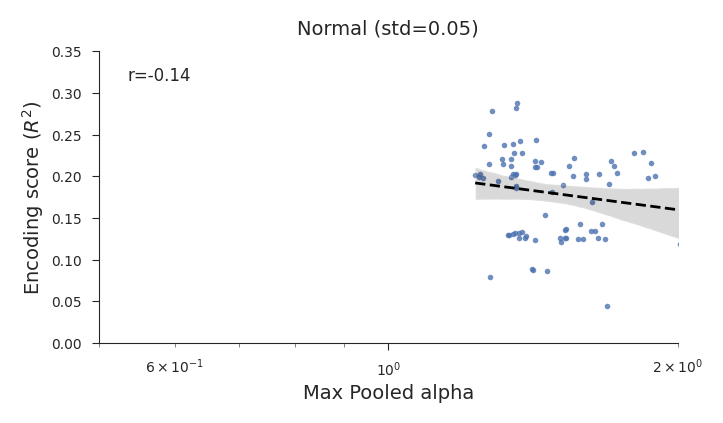

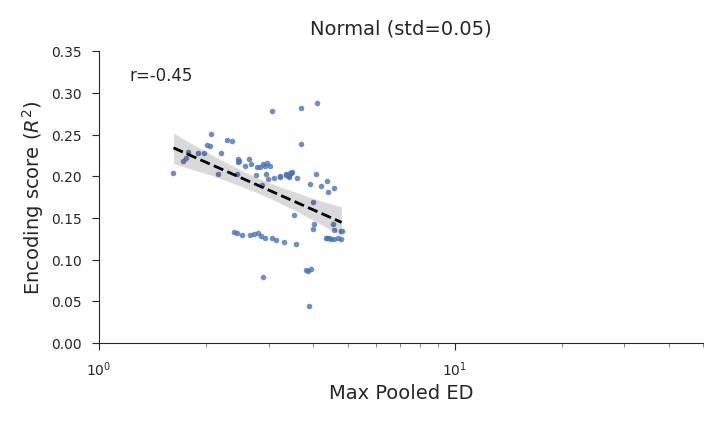

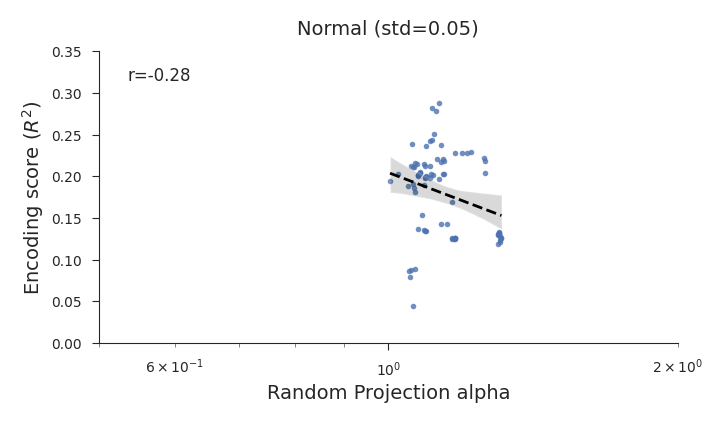

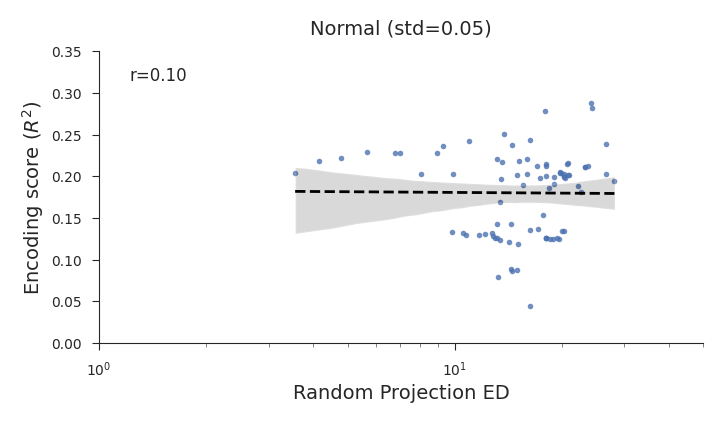

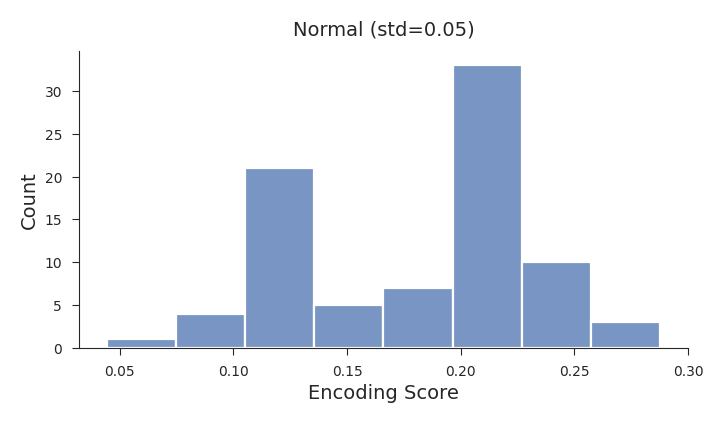

In [34]:
#normal encoding score

#max pooling
d1 = pd.read_csv(f'/home/wtownle1/encoder_dimensionality/results_marcc/untrained/encoding_N|benchmark:dicarlo.MajajHong2015.IT.public-pls|pooling:none.csv')
d2 = pd.read_csv(f'/home/wtownle1/encoder_dimensionality/results_marcc/untrained/eigmetrics_N|dataset:imagenet|pooling:max|grayscale:False.csv')
d2.loc[:, 'task'] = d2['task'].replace({'N_test': 'N'})
data = pd.merge(d1, d2, on=id_columns)


r, p = sp.stats.pearsonr(data['alpha'], data['score'])

fig, ax = plt.subplots(1, 1, figsize=(3.5, 2))

sns.regplot(data=data, x='alpha', y='score', 
            logx=True,
            scatter_kws={'alpha': 0.8, 's': 4, 'linewidth': 0}, 
            line_kws={'color': 'black', 'linestyle': '--', 'linewidth': 1}, 
            ax=ax)
ax.set(xlabel='Max Pooled alpha', ylabel=r'Encoding score ($R^2$)', xscale='log', title='Normal (std=0.05)')
ax.text(.05, .9, 'r={:.2f}'.format(r), transform=ax.transAxes)
ax.set_xlim(0.5, 2)
ax.set_ylim(bottom=0, top=0.35)
#plt.savefig('saved/results_ED-vs-encoding-all.png', dpi=300)
plt.show()


#ED to encoding score
r2, p2 = sp.stats.pearsonr(data['effective dimensionality'], data['score'])

fig, ax = plt.subplots(1, 1, figsize=(3.5, 2))

sns.regplot(data=data, x='effective dimensionality', y='score', 
            logx=True,
            scatter_kws={'alpha': 0.8, 's': 4, 'linewidth': 0}, 
            line_kws={'color': 'black', 'linestyle': '--', 'linewidth': 1}, 
            ax=ax)
ax.set(xlabel='Max Pooled ED', ylabel=r'Encoding score ($R^2$)', xscale='log', title='Normal (std=0.05)')
ax.text(.05, .9, 'r={:.2f}'.format(r2), transform=ax.transAxes)
ax.set_xlim(1, 50)
ax.set_ylim(bottom=0, top=0.35)
#plt.savefig('saved/results_ED-vs-encoding-all.png', dpi=300)
plt.show()


#random projection
data = pd.merge(pd.read_csv(f'../../results_marcc/untrained/encoding_N|benchmark:dicarlo.MajajHong2015.IT.public-pls|pooling:none.csv'),
                pd.read_csv(f'../../results_marcc/untrained/eigmetrics_N|dataset:imagenet|pooling:none|grayscale:False.csv'),
                on=id_columns)
data.loc[:, 'layer'] = data['layer'].replace(tf_to_pt_layer_map)

r, p = sp.stats.pearsonr(data['alpha'], data['score'])

fig, ax = plt.subplots(1, 1, figsize=(3.5, 2))

sns.regplot(data=data, x='alpha', y='score', 
            logx=True,
            scatter_kws={'alpha': 0.8, 's': 4, 'linewidth': 0}, 
            line_kws={'color': 'black', 'linestyle': '--', 'linewidth': 1}, 
            ax=ax)
ax.set(xlabel='Random Projection alpha', ylabel=r'Encoding score ($R^2$)', xscale='log', title='Normal (std=0.05)')
ax.text(.05, .9, 'r={:.2f}'.format(r), transform=ax.transAxes)
ax.set_xlim(0.5, 2)
ax.set_ylim(bottom=0, top=0.35)
#plt.savefig('saved/results_ED-vs-encoding-all.png', dpi=300)
plt.show()


#ED to encoding score
r2, p2 = sp.stats.pearsonr(data['effective dimensionality'], data['score'])

fig, ax = plt.subplots(1, 1, figsize=(3.5, 2))

sns.regplot(data=data, x='effective dimensionality', y='score', 
            logx=True,
            scatter_kws={'alpha': 0.8, 's': 4, 'linewidth': 0}, 
            line_kws={'color': 'black', 'linestyle': '--', 'linewidth': 1}, 
            ax=ax)
ax.set(xlabel='Random Projection ED', ylabel=r'Encoding score ($R^2$)', xscale='log', title='Normal (std=0.05)')
ax.text(.05, .9, 'r={:.2f}'.format(r2), transform=ax.transAxes)
ax.set_xlim(1, 50)
ax.set_ylim(bottom=0, top=0.35)
#plt.savefig('saved/results_ED-vs-encoding-all.png', dpi=300)
plt.show()

fig, ax = plt.subplots(figsize=(3.5, 2))
sns.histplot(data=data, x='score')
ax.set(xlabel='Encoding Score', title='Normal (std=0.05)')
plt.show()

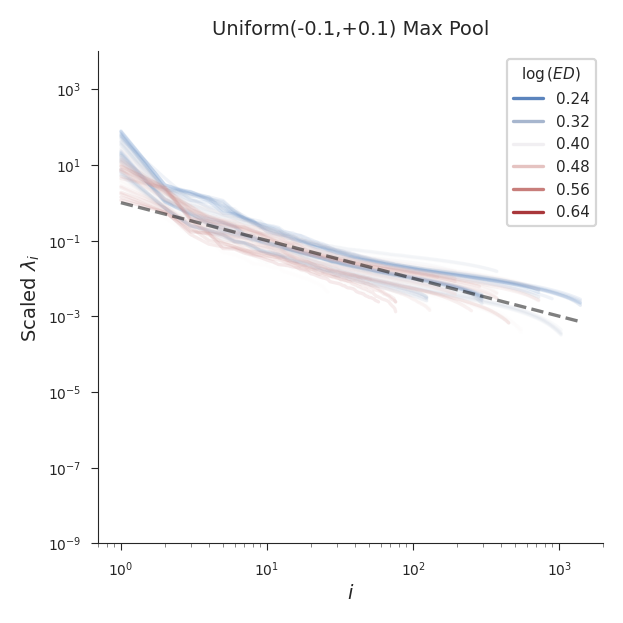

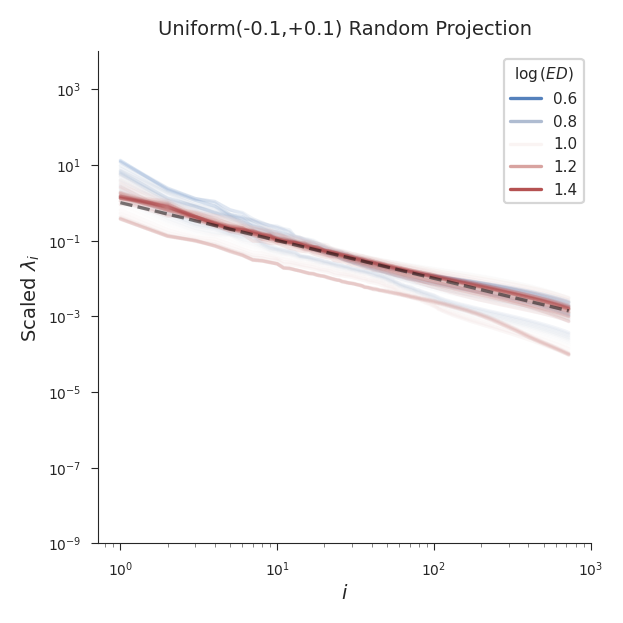

In [38]:
#uniform eigenspectra

#max pooling
data = pd.merge(pd.read_csv(f'../../results_marcc/untrained/eigspectra_Uni|dataset:imagenet|pooling:max|grayscale:False.csv'),
                pd.read_csv(f'../../results_marcc/untrained/eigmetrics_Uni|dataset:imagenet|pooling:max|grayscale:False.csv'),
                on=id_columns)
data.loc[:, 'layer'] = data['layer'].replace(tf_to_pt_layer_map)
data['id'] = data[id_columns].sum(axis='columns')

# Remove outlier low-variance points at the final PCs
def is_outlier(i):
    i = np.log(i)
    cutoff = 0.95 * i.iloc[-1]
    return i > cutoff
outlier = data.groupby(id_columns)['n'].transform(is_outlier)
data = data[~outlier]

# Set y-intercept to 1
def get_scaled_var(x):
    i, y = x['n'].values, x['variance'].values
    i, y = np.log(i), np.log(y)
    intercept = LinearRegression().fit(i.reshape(-1, 1), y).intercept_
    intercept = np.exp(intercept)
    return x['variance'] / intercept
scaled_var = data.groupby(id_columns).apply(get_scaled_var)
scaled_var = scaled_var.reset_index(id_columns, drop=True)
data['scaled_variance'] = scaled_var

# Log(ED)
data['log_ed'] = np.log10(data['effective dimensionality'])

fig, ax = plt.subplots(figsize=(3, 3))

sns.lineplot(data=data, x='n', y='scaled_variance', hue='log_ed',
             units='id', alpha=0.1, estimator=None,
             palette=sns.color_palette('vlag', as_cmap=True), ax=ax)
ax.plot([1, data.n.max()], [1, 1 / data.n.max()], linestyle='--', color='black', alpha=0.5)
ax.set(xlabel=r'$i$', ylabel=r'Scaled $\lambda_i$', xscale='log', yscale='log', title='Uniform(-0.1,+0.1) Max Pool')
ax.set_ylim(bottom=10**(-9), top=10**4)
ax.legend(title=r'$\log{(ED)}$')



#random projection
data = pd.merge(pd.read_csv(f'../../results_marcc/untrained/eigspectra_U|dataset:imagenet|pooling:none|grayscale:False.csv'),
                pd.read_csv(f'../../results_marcc/untrained/eigmetrics_U|dataset:imagenet|pooling:none|grayscale:False.csv'),
                on=id_columns)
data.loc[:, 'layer'] = data['layer'].replace(tf_to_pt_layer_map)
data['id'] = data[id_columns].sum(axis='columns')

# Remove outlier low-variance points at the final PCs
def is_outlier(i):
    i = np.log(i)
    cutoff = 0.95 * i.iloc[-1]
    return i > cutoff
outlier = data.groupby(id_columns)['n'].transform(is_outlier)
data = data[~outlier]

# Set y-intercept to 1
def get_scaled_var(x):
    i, y = x['n'].values, x['variance'].values
    i, y = np.log(i), np.log(y)
    intercept = LinearRegression().fit(i.reshape(-1, 1), y).intercept_
    intercept = np.exp(intercept)
    return x['variance'] / intercept
scaled_var = data.groupby(id_columns).apply(get_scaled_var)
scaled_var = scaled_var.reset_index(id_columns, drop=True)
data['scaled_variance'] = scaled_var

# Log(ED)
data['log_ed'] = np.log10(data['effective dimensionality'])

fig, ax = plt.subplots(figsize=(3, 3))

sns.lineplot(data=data, x='n', y='scaled_variance', hue='log_ed',
             units='id', alpha=0.1, estimator=None,
             palette=sns.color_palette('vlag', as_cmap=True), ax=ax)
ax.plot([1, data.n.max()], [1, 1 / data.n.max()], linestyle='--', color='black', alpha=0.5)
ax.set(xlabel=r'$i$', ylabel=r'Scaled $\lambda_i$', xscale='log', yscale='log', title='Uniform(-0.1,+0.1) Random Projection')
ax.set_ylim(bottom=10**(-9), top=10**4)
ax.legend(title=r'$\log{(ED)}$')

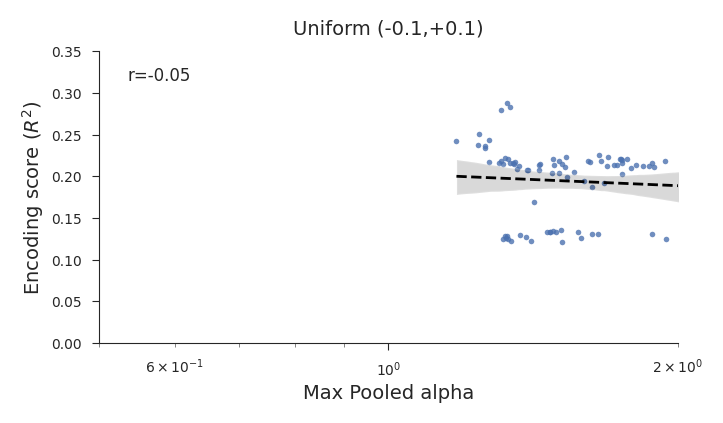

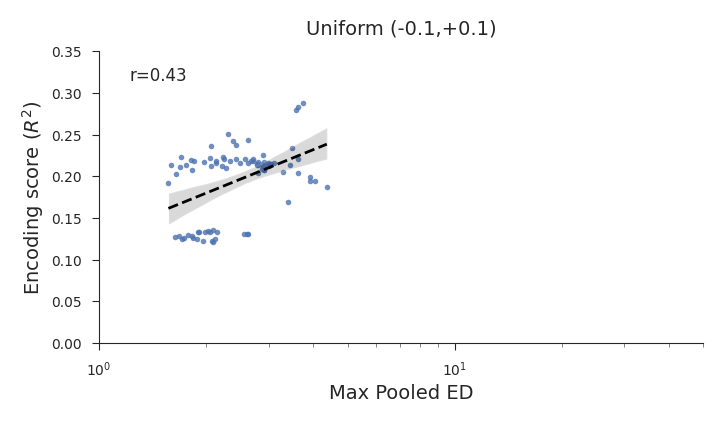

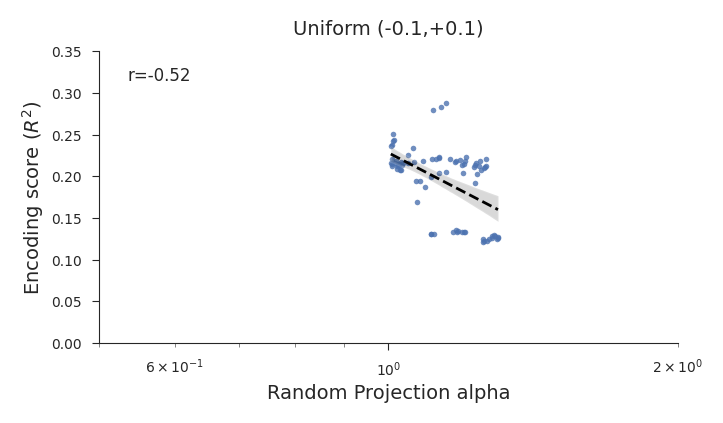

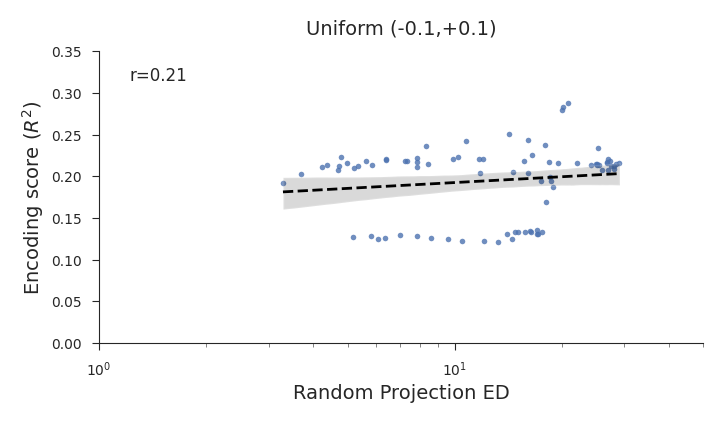

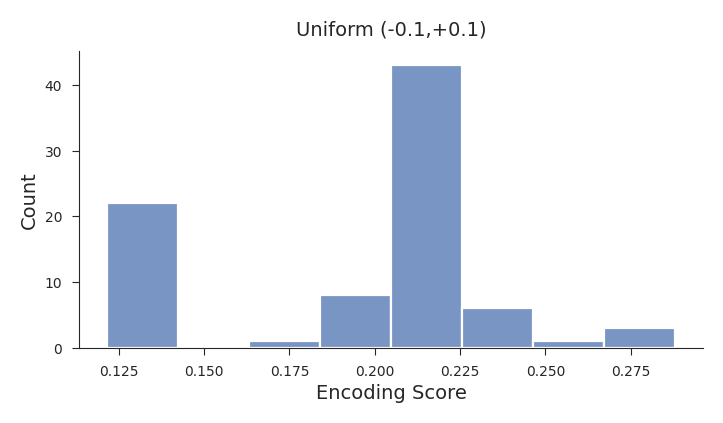

In [37]:
#uniform encoding score

#max pooling
d1 = pd.read_csv(f'/home/wtownle1/encoder_dimensionality/results_marcc/untrained/encoding_Uni|benchmark:dicarlo.MajajHong2015.IT.public-pls|pooling:none.csv')
d2 = pd.read_csv(f'/home/wtownle1/encoder_dimensionality/results_marcc/untrained/eigmetrics_Uni|dataset:imagenet|pooling:max|grayscale:False.csv')
d2.loc[:, 'task'] = d2['task'].replace({'U_test': 'U'})
data = pd.merge(d1, d2, on=id_columns)


r, p = sp.stats.pearsonr(data['alpha'], data['score'])

fig, ax = plt.subplots(1, 1, figsize=(3.5, 2))

sns.regplot(data=data, x='alpha', y='score', 
            logx=True,
            scatter_kws={'alpha': 0.8, 's': 4, 'linewidth': 0}, 
            line_kws={'color': 'black', 'linestyle': '--', 'linewidth': 1}, 
            ax=ax)
ax.set(xlabel='Max Pooled alpha', ylabel=r'Encoding score ($R^2$)', xscale='log', title='Uniform (-0.1,+0.1)')
ax.text(.05, .9, 'r={:.2f}'.format(r), transform=ax.transAxes)
ax.set_xlim(0.5, 2)
ax.set_ylim(bottom=0, top=0.35)
#plt.savefig('saved/results_ED-vs-encoding-all.png', dpi=300)
plt.show()


#ED to encoding score
r2, p2 = sp.stats.pearsonr(data['effective dimensionality'], data['score'])

fig, ax = plt.subplots(1, 1, figsize=(3.5, 2))

sns.regplot(data=data, x='effective dimensionality', y='score', 
            logx=True,
            scatter_kws={'alpha': 0.8, 's': 4, 'linewidth': 0}, 
            line_kws={'color': 'black', 'linestyle': '--', 'linewidth': 1}, 
            ax=ax)
ax.set(xlabel='Max Pooled ED', ylabel=r'Encoding score ($R^2$)', xscale='log', title='Uniform (-0.1,+0.1)')
ax.text(.05, .9, 'r={:.2f}'.format(r2), transform=ax.transAxes)
ax.set_xlim(1, 50)
ax.set_ylim(bottom=0, top=0.35)
#plt.savefig('saved/results_ED-vs-encoding-all.png', dpi=300)
plt.show()


#random projection
data = pd.merge(pd.read_csv(f'../../results_marcc/untrained/encoding_Uni|benchmark:dicarlo.MajajHong2015.IT.public-pls|pooling:none.csv'),
                pd.read_csv(f'../../results_marcc/untrained/eigmetrics_U|dataset:imagenet|pooling:none|grayscale:False.csv'),
                on=id_columns)
data.loc[:, 'layer'] = data['layer'].replace(tf_to_pt_layer_map)

r, p = sp.stats.pearsonr(data['alpha'], data['score'])

fig, ax = plt.subplots(1, 1, figsize=(3.5, 2))

sns.regplot(data=data, x='alpha', y='score', 
            logx=True,
            scatter_kws={'alpha': 0.8, 's': 4, 'linewidth': 0}, 
            line_kws={'color': 'black', 'linestyle': '--', 'linewidth': 1}, 
            ax=ax)
ax.set(xlabel='Random Projection alpha', ylabel=r'Encoding score ($R^2$)', xscale='log', title='Uniform (-0.1,+0.1)')
ax.text(.05, .9, 'r={:.2f}'.format(r), transform=ax.transAxes)
ax.set_xlim(0.5, 2)
ax.set_ylim(bottom=0, top=0.35)
#plt.savefig('saved/results_ED-vs-encoding-all.png', dpi=300)
plt.show()


#ED to encoding score
r2, p2 = sp.stats.pearsonr(data['effective dimensionality'], data['score'])

fig, ax = plt.subplots(1, 1, figsize=(3.5, 2))

sns.regplot(data=data, x='effective dimensionality', y='score', 
            logx=True,
            scatter_kws={'alpha': 0.8, 's': 4, 'linewidth': 0}, 
            line_kws={'color': 'black', 'linestyle': '--', 'linewidth': 1}, 
            ax=ax)
ax.set(xlabel='Random Projection ED', ylabel=r'Encoding score ($R^2$)', xscale='log', title='Uniform (-0.1,+0.1)')
ax.text(.05, .9, 'r={:.2f}'.format(r2), transform=ax.transAxes)
ax.set_xlim(1, 50)
ax.set_ylim(bottom=0, top=0.35)
#plt.savefig('saved/results_ED-vs-encoding-all.png', dpi=300)
plt.show()

fig, ax = plt.subplots(figsize=(3.5, 2))
sns.histplot(data=data, x='score')
ax.set(xlabel='Encoding Score', title='Uniform (-0.1,+0.1)')
plt.show()

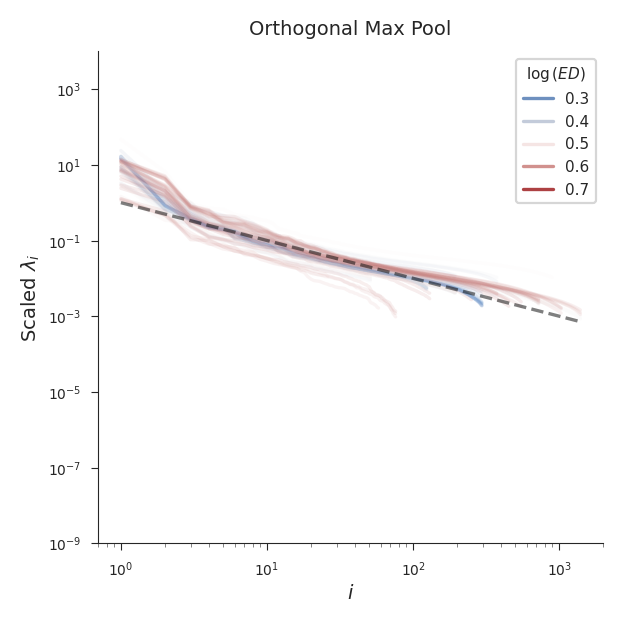

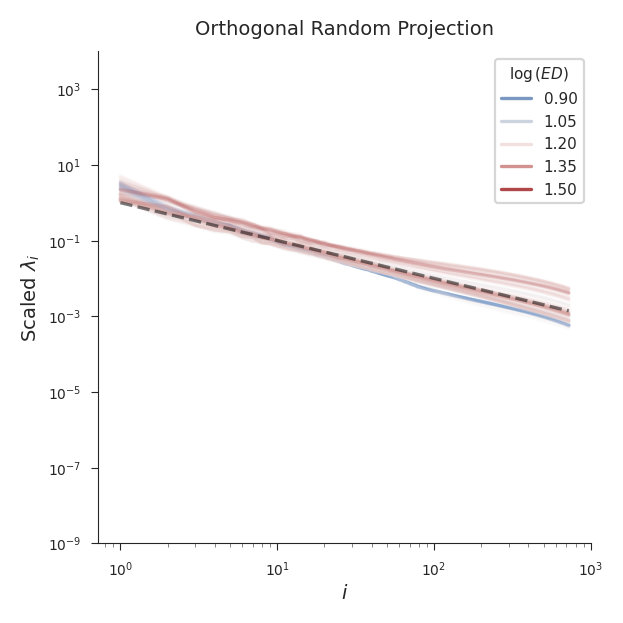

In [4]:
#orthogonal eigenspectra

#max pooling
data = pd.merge(pd.read_csv(f'../../results_marcc/untrained/eigspectra_O|dataset:imagenet|pooling:max|grayscale:False.csv'),
                pd.read_csv(f'../../results_marcc/untrained/eigmetrics_O|dataset:imagenet|pooling:max|grayscale:False.csv'),
                on=id_columns)
data.loc[:, 'layer'] = data['layer'].replace(tf_to_pt_layer_map)
data['id'] = data[id_columns].sum(axis='columns')

# Remove outlier low-variance points at the final PCs
def is_outlier(i):
    i = np.log(i)
    cutoff = 0.95 * i.iloc[-1]
    return i > cutoff
outlier = data.groupby(id_columns)['n'].transform(is_outlier)
data = data[~outlier]

# Set y-intercept to 1
def get_scaled_var(x):
    i, y = x['n'].values, x['variance'].values
    i, y = np.log(i), np.log(y)
    intercept = LinearRegression().fit(i.reshape(-1, 1), y).intercept_
    intercept = np.exp(intercept)
    return x['variance'] / intercept
scaled_var = data.groupby(id_columns).apply(get_scaled_var)
scaled_var = scaled_var.reset_index(id_columns, drop=True)
data['scaled_variance'] = scaled_var

# Log(ED)
data['log_ed'] = np.log10(data['effective dimensionality'])

fig, ax = plt.subplots(figsize=(3, 3))

sns.lineplot(data=data, x='n', y='scaled_variance', hue='log_ed',
             units='id', alpha=0.1, estimator=None,
             palette=sns.color_palette('vlag', as_cmap=True), ax=ax)
ax.plot([1, data.n.max()], [1, 1 / data.n.max()], linestyle='--', color='black', alpha=0.5)
ax.set(xlabel=r'$i$', ylabel=r'Scaled $\lambda_i$', xscale='log', yscale='log', title='Orthogonal Max Pool')
ax.set_ylim(bottom=10**(-9), top=10**4)
ax.legend(title=r'$\log{(ED)}$')



#random projection
data = pd.merge(pd.read_csv(f'../../results_marcc/untrained/eigspectra_O|dataset:imagenet|pooling:none|grayscale:False.csv'),
                pd.read_csv(f'../../results_marcc/untrained/eigmetrics_O|dataset:imagenet|pooling:none|grayscale:False.csv'),
                on=id_columns)
data.loc[:, 'layer'] = data['layer'].replace(tf_to_pt_layer_map)
data['id'] = data[id_columns].sum(axis='columns')

# Remove outlier low-variance points at the final PCs
def is_outlier(i):
    i = np.log(i)
    cutoff = 0.95 * i.iloc[-1]
    return i > cutoff
outlier = data.groupby(id_columns)['n'].transform(is_outlier)
data = data[~outlier]

# Set y-intercept to 1
def get_scaled_var(x):
    i, y = x['n'].values, x['variance'].values
    i, y = np.log(i), np.log(y)
    intercept = LinearRegression().fit(i.reshape(-1, 1), y).intercept_
    intercept = np.exp(intercept)
    return x['variance'] / intercept
scaled_var = data.groupby(id_columns).apply(get_scaled_var)
scaled_var = scaled_var.reset_index(id_columns, drop=True)
data['scaled_variance'] = scaled_var

# Log(ED)
data['log_ed'] = np.log10(data['effective dimensionality'])

fig, ax = plt.subplots(figsize=(3, 3))

sns.lineplot(data=data, x='n', y='scaled_variance', hue='log_ed',
             units='id', alpha=0.1, estimator=None,
             palette=sns.color_palette('vlag', as_cmap=True), ax=ax)
ax.plot([1, data.n.max()], [1, 1 / data.n.max()], linestyle='--', color='black', alpha=0.5)
ax.set(xlabel=r'$i$', ylabel=r'Scaled $\lambda_i$', xscale='log', yscale='log', title='Orthogonal Random Projection')
ax.set_ylim(bottom=10**(-9), top=10**4)
ax.legend(title=r'$\log{(ED)}$')

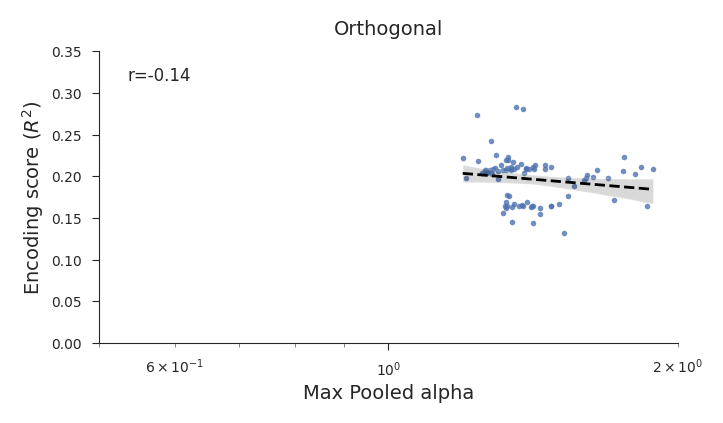

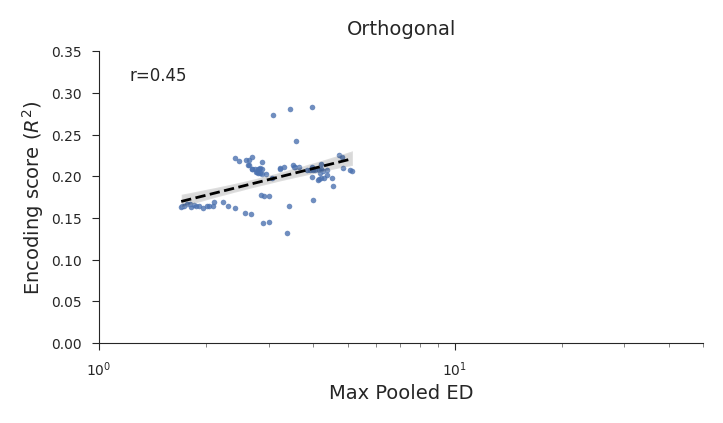

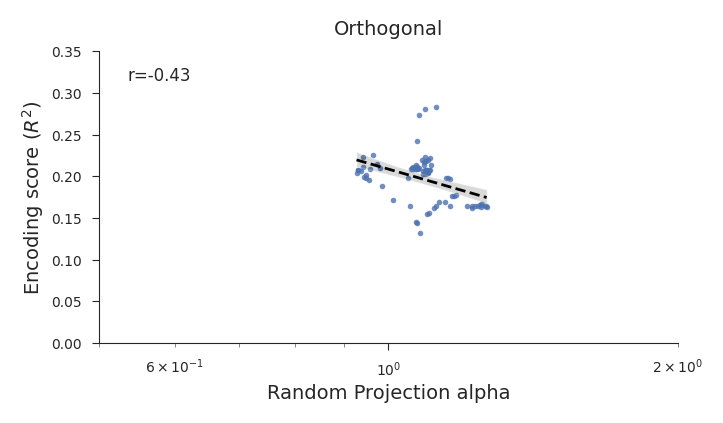

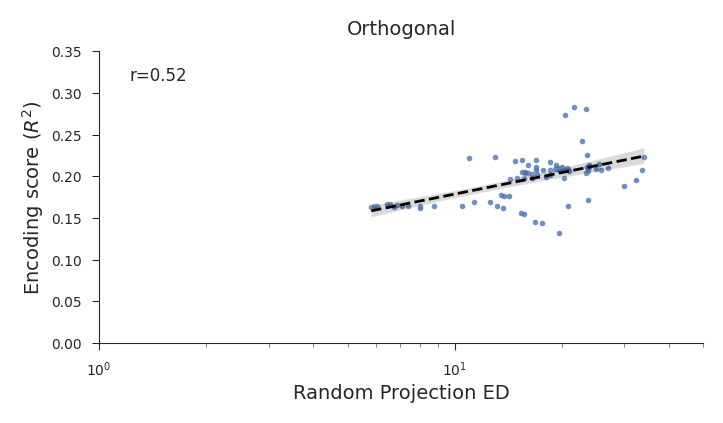

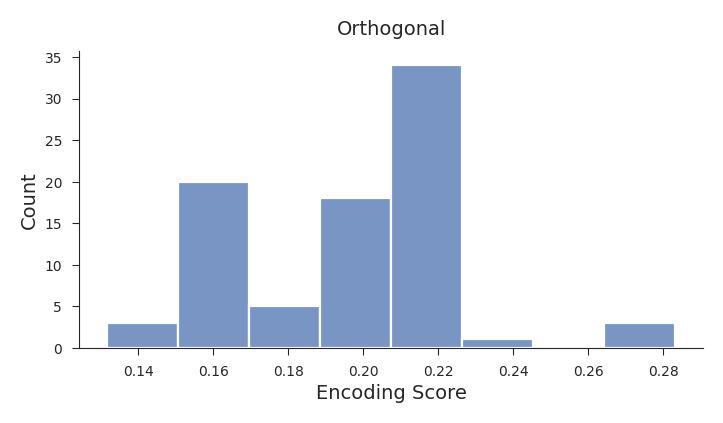

In [6]:
#orthogonal encoding score

#max pooling
d1 = pd.read_csv(f'/home/wtownle1/encoder_dimensionality/results_marcc/untrained/encoding_O|benchmark:dicarlo.MajajHong2015.IT.public-pls|pooling:none.csv')
d2 = pd.read_csv(f'/home/wtownle1/encoder_dimensionality/results_marcc/untrained/eigmetrics_O|dataset:imagenet|pooling:max|grayscale:False.csv')
d2.loc[:, 'task'] = d2['task'].replace({'U_test': 'U'})
data = pd.merge(d1, d2, on=id_columns)


r, p = sp.stats.pearsonr(data['alpha'], data['score'])

fig, ax = plt.subplots(1, 1, figsize=(3.5, 2))

sns.regplot(data=data, x='alpha', y='score', 
            logx=True,
            scatter_kws={'alpha': 0.8, 's': 4, 'linewidth': 0}, 
            line_kws={'color': 'black', 'linestyle': '--', 'linewidth': 1}, 
            ax=ax)
ax.set(xlabel='Max Pooled alpha', ylabel=r'Encoding score ($R^2$)', xscale='log', title='Orthogonal')
ax.text(.05, .9, 'r={:.2f}'.format(r), transform=ax.transAxes)
ax.set_xlim(0.5, 2)
ax.set_ylim(bottom=0, top=0.35)
#plt.savefig('saved/results_ED-vs-encoding-all.png', dpi=300)
plt.show()


#ED to encoding score
r2, p2 = sp.stats.pearsonr(data['effective dimensionality'], data['score'])

fig, ax = plt.subplots(1, 1, figsize=(3.5, 2))

sns.regplot(data=data, x='effective dimensionality', y='score', 
            logx=True,
            scatter_kws={'alpha': 0.8, 's': 4, 'linewidth': 0}, 
            line_kws={'color': 'black', 'linestyle': '--', 'linewidth': 1}, 
            ax=ax)
ax.set(xlabel='Max Pooled ED', ylabel=r'Encoding score ($R^2$)', xscale='log', title='Orthogonal')
ax.text(.05, .9, 'r={:.2f}'.format(r2), transform=ax.transAxes)
ax.set_xlim(1, 50)
ax.set_ylim(bottom=0, top=0.35)
#plt.savefig('saved/results_ED-vs-encoding-all.png', dpi=300)
plt.show()


#random projection
data = pd.merge(pd.read_csv(f'../../results_marcc/untrained/encoding_O|benchmark:dicarlo.MajajHong2015.IT.public-pls|pooling:none.csv'),
                pd.read_csv(f'../../results_marcc/untrained/eigmetrics_O|dataset:imagenet|pooling:none|grayscale:False.csv'),
                on=id_columns)
data.loc[:, 'layer'] = data['layer'].replace(tf_to_pt_layer_map)

r, p = sp.stats.pearsonr(data['alpha'], data['score'])

fig, ax = plt.subplots(1, 1, figsize=(3.5, 2))

sns.regplot(data=data, x='alpha', y='score', 
            logx=True,
            scatter_kws={'alpha': 0.8, 's': 4, 'linewidth': 0}, 
            line_kws={'color': 'black', 'linestyle': '--', 'linewidth': 1}, 
            ax=ax)
ax.set(xlabel='Random Projection alpha', ylabel=r'Encoding score ($R^2$)', xscale='log', title='Orthogonal')
ax.text(.05, .9, 'r={:.2f}'.format(r), transform=ax.transAxes)
ax.set_xlim(0.5, 2)
ax.set_ylim(bottom=0, top=0.35)
#plt.savefig('saved/results_ED-vs-encoding-all.png', dpi=300)
plt.show()


#ED to encoding score
r2, p2 = sp.stats.pearsonr(data['effective dimensionality'], data['score'])

fig, ax = plt.subplots(1, 1, figsize=(3.5, 2))

sns.regplot(data=data, x='effective dimensionality', y='score', 
            logx=True,
            scatter_kws={'alpha': 0.8, 's': 4, 'linewidth': 0}, 
            line_kws={'color': 'black', 'linestyle': '--', 'linewidth': 1}, 
            ax=ax)
ax.set(xlabel='Random Projection ED', ylabel=r'Encoding score ($R^2$)', xscale='log', title='Orthogonal')
ax.text(.05, .9, 'r={:.2f}'.format(r2), transform=ax.transAxes)
ax.set_xlim(1, 50)
ax.set_ylim(bottom=0, top=0.35)
#plt.savefig('saved/results_ED-vs-encoding-all.png', dpi=300)
plt.show()

fig, ax = plt.subplots(figsize=(3.5, 2))
sns.histplot(data=data, x='score')
ax.set(xlabel='Encoding Score', title='Orthogonal')
plt.show()

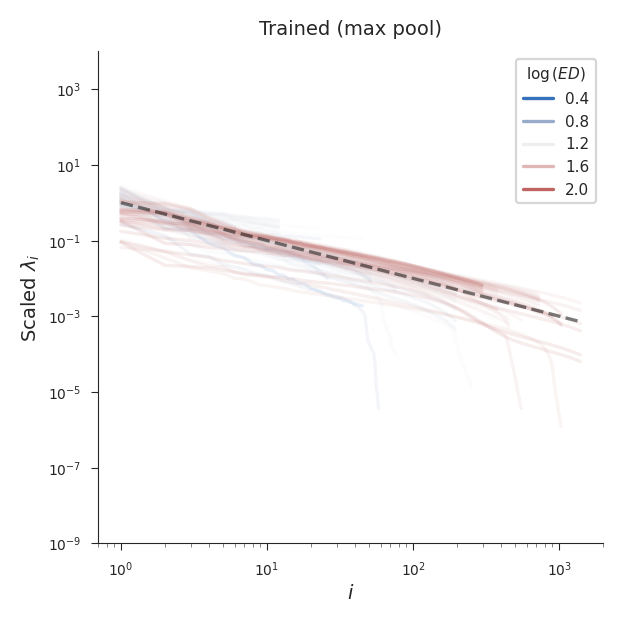

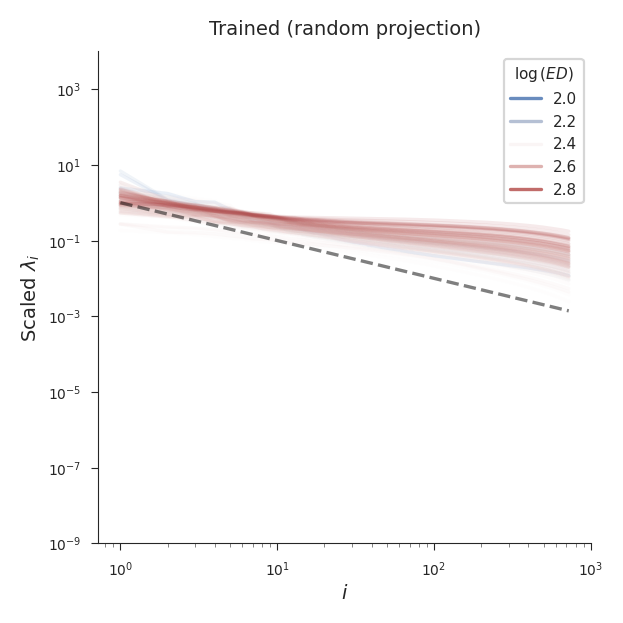

In [17]:
#trained eigenspectra
# - CNNs include convnext

#max pooling
data = pd.merge(pd.read_csv(f'../../results_marcc/untrained/eigspectra_pytrch|dataset:imagenet|pooling:max|grayscale:False.csv'),
                pd.read_csv(f'../../results_marcc/untrained/eigmetrics_pytrch|dataset:imagenet|pooling:max|grayscale:False.csv'),
                on=id_columns)
data.loc[:, 'layer'] = data['layer'].replace(tf_to_pt_layer_map)
data['id'] = data[id_columns].sum(axis='columns')
data = data[ (data['architecture'] != 'MaxViT') & (data['architecture'] != 'Swin_t') & (data['architecture'] != 'VGG16')]

# Remove outlier low-variance points at the final PCs
def is_outlier(i):
    i = np.log(i)
    cutoff = 0.95 * i.iloc[-1]
    return i > cutoff
outlier = data.groupby(id_columns)['n'].transform(is_outlier)
data = data[~outlier]

# Set y-intercept to 1
def get_scaled_var(x):
    i, y = x['n'].values, x['variance'].values
    i, y = np.log(i), np.log(y)
    intercept = LinearRegression().fit(i.reshape(-1, 1), y).intercept_
    intercept = np.exp(intercept)
    return x['variance'] / intercept
scaled_var = data.groupby(id_columns).apply(get_scaled_var)
scaled_var = scaled_var.reset_index(id_columns, drop=True)
data['scaled_variance'] = scaled_var

# Log(ED)
data['log_ed'] = np.log10(data['effective dimensionality'])

fig, ax = plt.subplots(figsize=(3, 3))

sns.lineplot(data=data, x='n', y='scaled_variance', hue='log_ed',
             units='id', alpha=0.1, estimator=None,
             palette=sns.color_palette('vlag', as_cmap=True), ax=ax)
ax.plot([1, data.n.max()], [1, 1 / data.n.max()], linestyle='--', color='black', alpha=0.5)
ax.set(xlabel=r'$i$', ylabel=r'Scaled $\lambda_i$', xscale='log', yscale='log', title='Trained (max pool)')
ax.set_ylim(bottom=10**(-9), top=10**4)
ax.legend(title=r'$\log{(ED)}$')


#random projection
data = pd.merge(pd.read_csv(f'../../results_marcc/untrained/eigspectra_pytrch|dataset:imagenet|pooling:none|grayscale:False.csv'),
                pd.read_csv(f'../../results_marcc/untrained/eigmetrics_pytrch|dataset:imagenet|pooling:none|grayscale:False.csv'),
                on=id_columns)
data.loc[:, 'layer'] = data['layer'].replace(tf_to_pt_layer_map)
data['id'] = data[id_columns].sum(axis='columns')
data = data[ (data['architecture'] != 'MaxViT') & (data['architecture'] != 'Swin_t') & (data['architecture'] != 'VGG16')]

# Remove outlier low-variance points at the final PCs
def is_outlier(i):
    i = np.log(i)
    cutoff = 0.95 * i.iloc[-1]
    return i > cutoff
outlier = data.groupby(id_columns)['n'].transform(is_outlier)
data = data[~outlier]

# Set y-intercept to 1
def get_scaled_var(x):
    i, y = x['n'].values, x['variance'].values
    i, y = np.log(i), np.log(y)
    intercept = LinearRegression().fit(i.reshape(-1, 1), y).intercept_
    intercept = np.exp(intercept)
    return x['variance'] / intercept
scaled_var = data.groupby(id_columns).apply(get_scaled_var)
scaled_var = scaled_var.reset_index(id_columns, drop=True)
data['scaled_variance'] = scaled_var

# Log(ED)
data['log_ed'] = np.log10(data['effective dimensionality'])

fig, ax = plt.subplots(figsize=(3, 3))

sns.lineplot(data=data, x='n', y='scaled_variance', hue='log_ed',
             units='id', alpha=0.1, estimator=None,
             palette=sns.color_palette('vlag', as_cmap=True), ax=ax)
ax.plot([1, data.n.max()], [1, 1 / data.n.max()], linestyle='--', color='black', alpha=0.5)
ax.set(xlabel=r'$i$', ylabel=r'Scaled $\lambda_i$', xscale='log', yscale='log', title='Trained (random projection)')
ax.set_ylim(bottom=10**(-9), top=10**4)
ax.legend(title=r'$\log{(ED)}$')



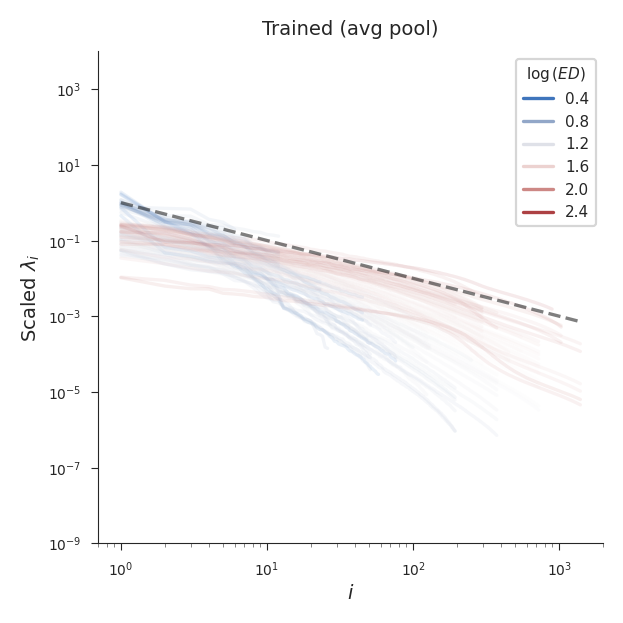

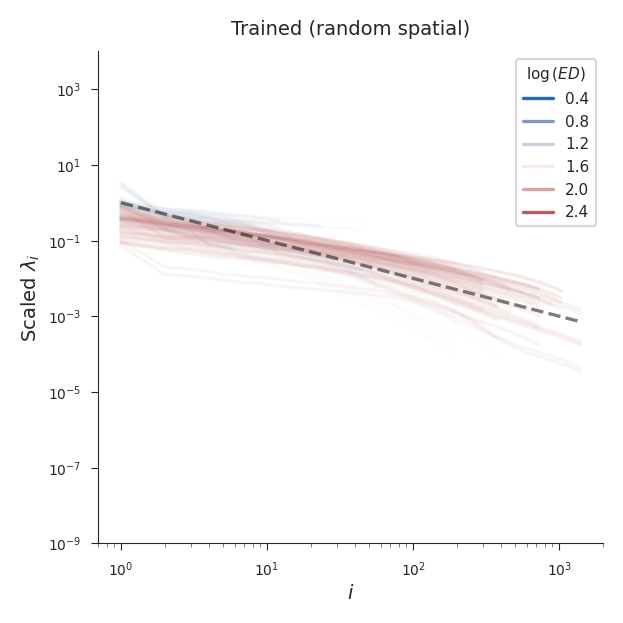

In [18]:
#trained eigenspectra

#avg pooling
data = pd.merge(pd.read_csv(f'../../results_marcc/untrained/eigspectra_pytrch|dataset:imagenet|pooling:avg|grayscale:False.csv'),
                pd.read_csv(f'../../results_marcc/untrained/eigmetrics_pytrch|dataset:imagenet|pooling:avg|grayscale:False.csv'),
                on=id_columns)
data.loc[:, 'layer'] = data['layer'].replace(tf_to_pt_layer_map)
data['id'] = data[id_columns].sum(axis='columns')
data = data[ (data['architecture'] != 'MaxViT') & (data['architecture'] != 'Swin_t') & (data['architecture'] != 'VGG16')]

# Remove outlier low-variance points at the final PCs
def is_outlier(i):
    i = np.log(i)
    cutoff = 0.95 * i.iloc[-1]
    return i > cutoff
outlier = data.groupby(id_columns)['n'].transform(is_outlier)
data = data[~outlier]

# Set y-intercept to 1
def get_scaled_var(x):
    i, y = x['n'].values, x['variance'].values
    i, y = np.log(i), np.log(y)
    intercept = LinearRegression().fit(i.reshape(-1, 1), y).intercept_
    intercept = np.exp(intercept)
    return x['variance'] / intercept
scaled_var = data.groupby(id_columns).apply(get_scaled_var)
scaled_var = scaled_var.reset_index(id_columns, drop=True)
data['scaled_variance'] = scaled_var

# Log(ED)
data['log_ed'] = np.log10(data['effective dimensionality'])

fig, ax = plt.subplots(figsize=(3, 3))

sns.lineplot(data=data, x='n', y='scaled_variance', hue='log_ed',
             units='id', alpha=0.1, estimator=None,
             palette=sns.color_palette('vlag', as_cmap=True), ax=ax)
ax.plot([1, data.n.max()], [1, 1 / data.n.max()], linestyle='--', color='black', alpha=0.5)
ax.set(xlabel=r'$i$', ylabel=r'Scaled $\lambda_i$', xscale='log', yscale='log', title='Trained (avg pool)')
ax.set_ylim(bottom=10**(-9), top=10**4)
ax.legend(title=r'$\log{(ED)}$')


#random spatial
data = pd.merge(pd.read_csv(f'../../results_marcc/untrained/eigspectra_pytrch|dataset:imagenet|pooling:random_spatial|grayscale:False.csv'),
                pd.read_csv(f'../../results_marcc/untrained/eigmetrics_pytrch|dataset:imagenet|pooling:random_spatial|grayscale:False.csv'),
                on=id_columns)
data.loc[:, 'layer'] = data['layer'].replace(tf_to_pt_layer_map)
data['id'] = data[id_columns].sum(axis='columns')
data = data[ (data['architecture'] != 'MaxViT') & (data['architecture'] != 'Swin_t') & (data['architecture'] != 'VGG16')]

# Remove outlier low-variance points at the final PCs
def is_outlier(i):
    i = np.log(i)
    cutoff = 0.95 * i.iloc[-1]
    return i > cutoff
outlier = data.groupby(id_columns)['n'].transform(is_outlier)
data = data[~outlier]

# Set y-intercept to 1
def get_scaled_var(x):
    i, y = x['n'].values, x['variance'].values
    i, y = np.log(i), np.log(y)
    intercept = LinearRegression().fit(i.reshape(-1, 1), y).intercept_
    intercept = np.exp(intercept)
    return x['variance'] / intercept
scaled_var = data.groupby(id_columns).apply(get_scaled_var)
scaled_var = scaled_var.reset_index(id_columns, drop=True)
data['scaled_variance'] = scaled_var

# Log(ED)
data['log_ed'] = np.log10(data['effective dimensionality'])

fig, ax = plt.subplots(figsize=(3, 3))

sns.lineplot(data=data, x='n', y='scaled_variance', hue='log_ed',
             units='id', alpha=0.1, estimator=None,
             palette=sns.color_palette('vlag', as_cmap=True), ax=ax)
ax.plot([1, data.n.max()], [1, 1 / data.n.max()], linestyle='--', color='black', alpha=0.5)
ax.set(xlabel=r'$i$', ylabel=r'Scaled $\lambda_i$', xscale='log', yscale='log', title='Trained (random spatial)')
ax.set_ylim(bottom=10**(-9), top=10**4)
ax.legend(title=r'$\log{(ED)}$')

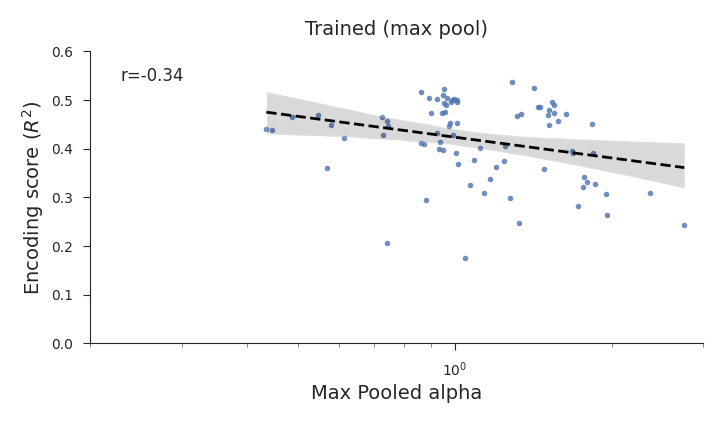

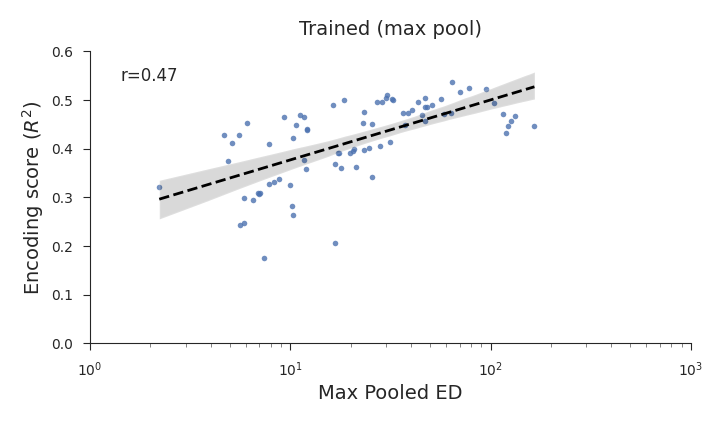

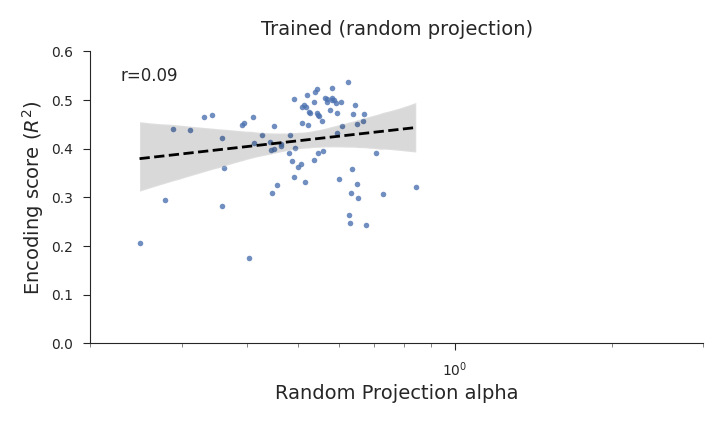

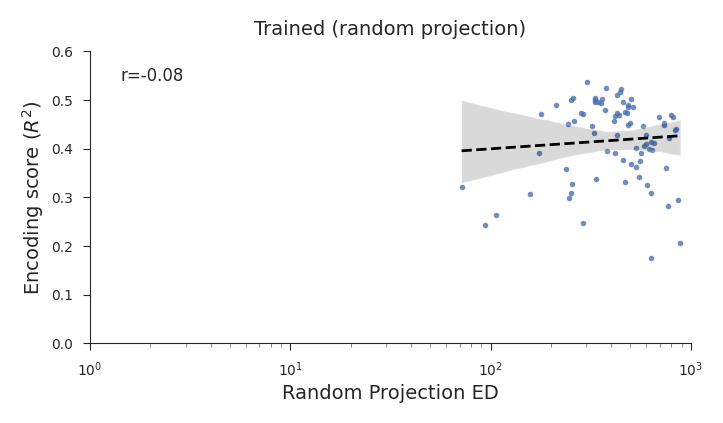

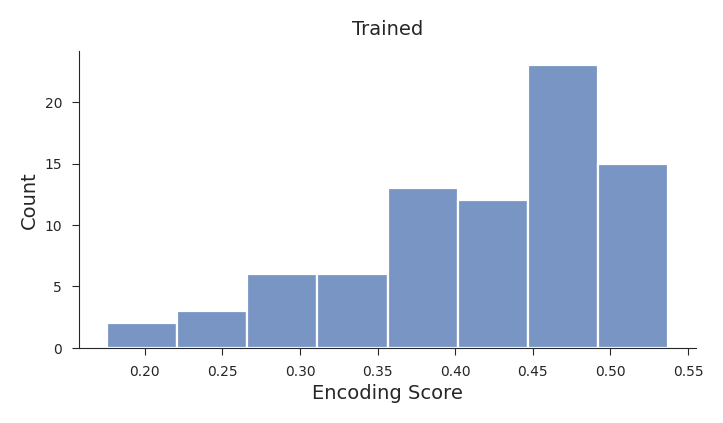

In [15]:
#trained encoding score
# - cnn includes convnext

#max pooling
d1 = pd.read_csv(f'../../results_marcc/untrained/encoding|benchmark:dicarlo.MajajHong2015.IT.public-pls|pooling:none.csv')
d1.loc[:, 'kind'] = d1['kind'].replace({'Sprvsd':'Supervised'})
d1.loc[:, 'task'] = d1['task'].replace({'Obj.Class.':'Object Classification'})
d1 = d1[ (d1['kind'] == 'Supervised') ]
d2 = pd.read_csv(f'../../results_marcc/untrained/eigmetrics_pytrch|dataset:imagenet|pooling:max|grayscale:False.csv')
d2 = d2[ (d2['architecture'] != 'MaxViT') & (d2['architecture'] != 'Swin_t') & (d2['architecture'] != 'VGG16')]
d2.loc[:, 'architecture'] = d2['architecture'].replace({'MNASNet1_4':'MNASNet13'})
d2.loc[:, 'architecture'] = d2['architecture'].replace({'RegNet_400mf':'RegNet400mf'})
data = pd.merge(d1, d2, on=id_columns)
data.loc[:, 'layer'] = data['layer'].replace(tf_to_pt_layer_map)

r, p = sp.stats.pearsonr(data['alpha'], data['score'])

fig, ax = plt.subplots(1, 1, figsize=(3.5, 2))

sns.regplot(data=data, x='alpha', y='score', 
            logx=True,
            scatter_kws={'alpha': 0.8, 's': 4, 'linewidth': 0}, 
            line_kws={'color': 'black', 'linestyle': '--', 'linewidth': 1}, 
            ax=ax)
ax.set(xlabel='Max Pooled alpha', ylabel=r'Encoding score ($R^2$)', xscale='log', title='Trained (max pool)')
ax.text(.05, .9, 'r={:.2f}'.format(r), transform=ax.transAxes)
ax.set_xlim(0.2, 3)
ax.set_ylim(bottom=0, top=0.6)
#plt.savefig('saved/results_ED-vs-encoding-all.png', dpi=300)
plt.show()

#ED
r, p = sp.stats.pearsonr(data['effective dimensionality'], data['score'])

fig, ax = plt.subplots(1, 1, figsize=(3.5, 2))

sns.regplot(data=data, x='effective dimensionality', y='score', 
            logx=True,
            scatter_kws={'alpha': 0.8, 's': 4, 'linewidth': 0}, 
            line_kws={'color': 'black', 'linestyle': '--', 'linewidth': 1}, 
            ax=ax)
ax.set(xlabel='Max Pooled ED', ylabel=r'Encoding score ($R^2$)', xscale='log', title='Trained (max pool)')
ax.text(.05, .9, 'r={:.2f}'.format(r), transform=ax.transAxes)
ax.set_xlim(1, 1000)
ax.set_ylim(bottom=0, top=0.6)
#plt.savefig('saved/results_ED-vs-encoding-all.png', dpi=300)
plt.show()


#no pooling
d1 = pd.read_csv(f'../../results_marcc/untrained/encoding|benchmark:dicarlo.MajajHong2015.IT.public-pls|pooling:none.csv')
d1.loc[:, 'kind'] = d1['kind'].replace({'Sprvsd':'Supervised'})
d1.loc[:, 'task'] = d1['task'].replace({'Obj.Class.':'Object Classification'})
d1 = d1[ (d1['kind'] == 'Supervised') ]
d2 = pd.read_csv(f'../../results_marcc/untrained/eigmetrics_pytrch|dataset:imagenet|pooling:none|grayscale:False.csv')
d2 = d2[ (d2['architecture'] != 'MaxViT') & (d2['architecture'] != 'Swin_t') & (d2['architecture'] != 'VGG16')]
d2.loc[:, 'architecture'] = d2['architecture'].replace({'MNASNet1_4':'MNASNet13'})
d2.loc[:, 'architecture'] = d2['architecture'].replace({'RegNet_400mf':'RegNet400mf'})
data = pd.merge(d1, d2, on=id_columns)
data.loc[:, 'layer'] = data['layer'].replace(tf_to_pt_layer_map)

r_np, p_np = sp.stats.pearsonr(data['alpha'], data['score'])

fig, ax = plt.subplots(1, 1, figsize=(3.5, 2))


sns.regplot(data=data, x='alpha', y='score', 
            logx=True,
            scatter_kws={'alpha': 0.8, 's': 4, 'linewidth': 0}, 
            line_kws={'color': 'black', 'linestyle': '--', 'linewidth': 1}, 
            ax=ax)
ax.set(xlabel='Random Projection alpha', ylabel=r'Encoding score ($R^2$)', xscale='log', title='Trained (random projection)')
ax.text(.05, .9, 'r={:.2f}'.format(r_np), transform=ax.transAxes)
ax.set_xlim(0.2, 3)
ax.set_ylim(bottom=0, top=0.6)
#plt.savefig('saved/results_ED-vs-encoding-all.png', dpi=300)
plt.show()


#ED
r_np, p_np = sp.stats.pearsonr(data['effective dimensionality'], data['score'])

fig, ax = plt.subplots(1, 1, figsize=(3.5, 2))


sns.regplot(data=data, x='effective dimensionality', y='score', 
            logx=True,
            scatter_kws={'alpha': 0.8, 's': 4, 'linewidth': 0}, 
            line_kws={'color': 'black', 'linestyle': '--', 'linewidth': 1}, 
            ax=ax)
ax.set(xlabel='Random Projection ED', ylabel=r'Encoding score ($R^2$)', xscale='log', title='Trained (random projection)')
ax.text(.05, .9, 'r={:.2f}'.format(r_np), transform=ax.transAxes)
ax.set_xlim(1, 1000)
ax.set_ylim(bottom=0, top=0.6)
#plt.savefig('saved/results_ED-vs-encoding-all.png', dpi=300)
plt.show()

fig, ax = plt.subplots(figsize=(3.5, 2))
sns.histplot(data=data, x='score')
ax.set(xlabel='Encoding Score', title='Trained')
plt.show()

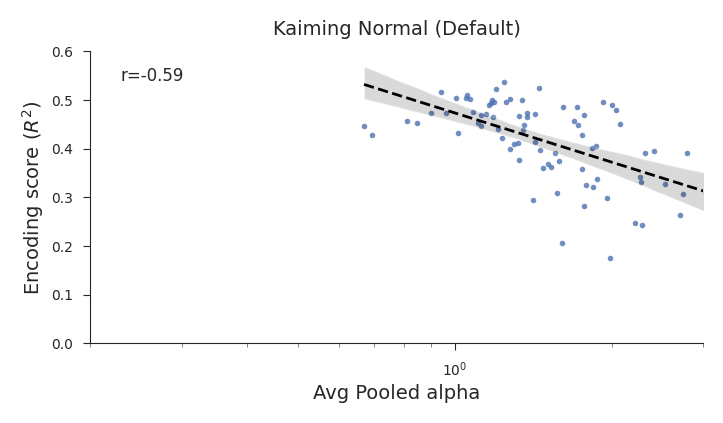

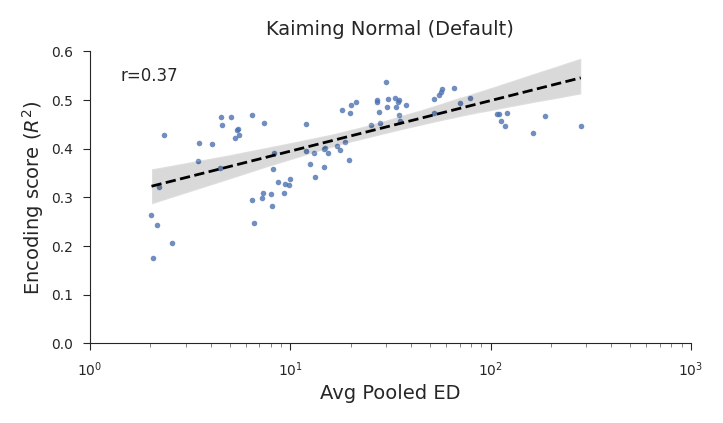

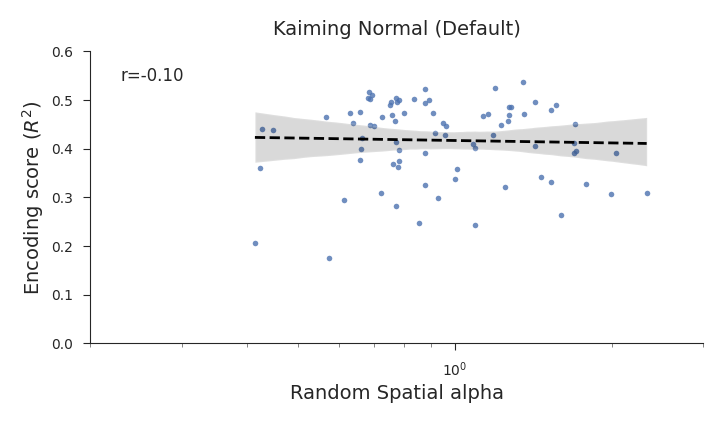

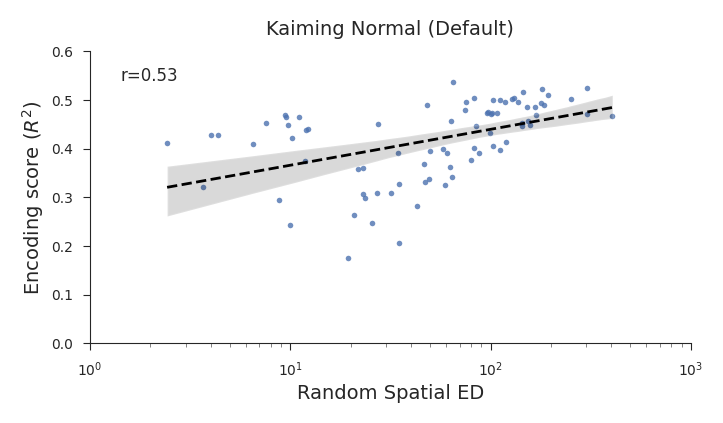

In [20]:
#kaiming normal (default) encoding score

#avg pooling
d1 = pd.read_csv(f'../../results_marcc/untrained/encoding|benchmark:dicarlo.MajajHong2015.IT.public-pls|pooling:none.csv')
d1.loc[:, 'kind'] = d1['kind'].replace({'Sprvsd':'Supervised'})
d1.loc[:, 'task'] = d1['task'].replace({'Obj.Class.':'Object Classification'})
d1 = d1[ (d1['kind'] == 'Supervised') ]
d2 = pd.read_csv(f'../../results_marcc/untrained/eigmetrics_pytrch|dataset:imagenet|pooling:avg|grayscale:False.csv')
d2 = d2[ (d2['architecture'] != 'MaxViT') & (d2['architecture'] != 'Swin_t') & (d2['architecture'] != 'VGG16')]
d2.loc[:, 'architecture'] = d2['architecture'].replace({'MNASNet1_4':'MNASNet13'})
d2.loc[:, 'architecture'] = d2['architecture'].replace({'RegNet_400mf':'RegNet400mf'})
data = pd.merge(d1, d2, on=id_columns)
data.loc[:, 'layer'] = data['layer'].replace(tf_to_pt_layer_map)


r, p = sp.stats.pearsonr(data['alpha'], data['score'])

fig, ax = plt.subplots(1, 1, figsize=(3.5, 2))

sns.regplot(data=data, x='alpha', y='score', 
            logx=True,
            scatter_kws={'alpha': 0.8, 's': 4, 'linewidth': 0}, 
            line_kws={'color': 'black', 'linestyle': '--', 'linewidth': 1}, 
            ax=ax)
ax.set(xlabel='Avg Pooled alpha', ylabel=r'Encoding score ($R^2$)', xscale='log', title='Kaiming Normal (Default)')
ax.text(.05, .9, 'r={:.2f}'.format(r), transform=ax.transAxes)
ax.set_xlim(0.2, 3)
ax.set_ylim(bottom=0, top=0.6)
#plt.savefig('saved/results_ED-vs-encoding-all.png', dpi=300)
plt.show()

#ED
r, p = sp.stats.pearsonr(data['effective dimensionality'], data['score'])

fig, ax = plt.subplots(1, 1, figsize=(3.5, 2))

sns.regplot(data=data, x='effective dimensionality', y='score', 
            logx=True,
            scatter_kws={'alpha': 0.8, 's': 4, 'linewidth': 0}, 
            line_kws={'color': 'black', 'linestyle': '--', 'linewidth': 1}, 
            ax=ax)
ax.set(xlabel='Avg Pooled ED', ylabel=r'Encoding score ($R^2$)', xscale='log', title='Kaiming Normal (Default)')
ax.text(.05, .9, 'r={:.2f}'.format(r), transform=ax.transAxes)
ax.set_xlim(1, 1000)
ax.set_ylim(bottom=0, top=0.6)
#plt.savefig('saved/results_ED-vs-encoding-all.png', dpi=300)
plt.show()


#random spatial
d1 = pd.read_csv(f'../../results_marcc/untrained/encoding|benchmark:dicarlo.MajajHong2015.IT.public-pls|pooling:none.csv')
d1.loc[:, 'kind'] = d1['kind'].replace({'Sprvsd':'Supervised'})
d1.loc[:, 'task'] = d1['task'].replace({'Obj.Class.':'Object Classification'})
d1 = d1[ (d1['kind'] == 'Supervised') ]
d2 = pd.read_csv(f'../../results_marcc/untrained/eigmetrics_pytrch|dataset:imagenet|pooling:random_spatial|grayscale:False.csv')
d2 = d2[ (d2['architecture'] != 'MaxViT') & (d2['architecture'] != 'Swin_t') & (d2['architecture'] != 'VGG16')]
d2.loc[:, 'architecture'] = d2['architecture'].replace({'MNASNet1_4':'MNASNet13'})
d2.loc[:, 'architecture'] = d2['architecture'].replace({'RegNet_400mf':'RegNet400mf'})
data = pd.merge(d1, d2, on=id_columns)
data.loc[:, 'layer'] = data['layer'].replace(tf_to_pt_layer_map)

r_np, p_np = sp.stats.pearsonr(data['alpha'], data['score'])

fig, ax = plt.subplots(1, 1, figsize=(3.5, 2))


sns.regplot(data=data, x='alpha', y='score', 
            logx=True,
            scatter_kws={'alpha': 0.8, 's': 4, 'linewidth': 0}, 
            line_kws={'color': 'black', 'linestyle': '--', 'linewidth': 1}, 
            ax=ax)
ax.set(xlabel='Random Spatial alpha', ylabel=r'Encoding score ($R^2$)', xscale='log', title='Kaiming Normal (Default)')
ax.text(.05, .9, 'r={:.2f}'.format(r_np), transform=ax.transAxes)
ax.set_xlim(0.2, 3)
ax.set_ylim(bottom=0, top=0.6)
#plt.savefig('saved/results_ED-vs-encoding-all.png', dpi=300)
plt.show()


#ED
r_np, p_np = sp.stats.pearsonr(data['effective dimensionality'], data['score'])

fig, ax = plt.subplots(1, 1, figsize=(3.5, 2))


sns.regplot(data=data, x='effective dimensionality', y='score', 
            logx=True,
            scatter_kws={'alpha': 0.8, 's': 4, 'linewidth': 0}, 
            line_kws={'color': 'black', 'linestyle': '--', 'linewidth': 1}, 
            ax=ax)
ax.set(xlabel='Random Spatial ED', ylabel=r'Encoding score ($R^2$)', xscale='log', title='Kaiming Normal (Default)')
ax.text(.05, .9, 'r={:.2f}'.format(r_np), transform=ax.transAxes)
ax.set_xlim(1, 1000)
ax.set_ylim(bottom=0, top=0.6)
#plt.savefig('saved/results_ED-vs-encoding-all.png', dpi=300)
plt.show()